<a href="https://colab.research.google.com/github/lauren-esser/Better-Stock-Market-Prediction/blob/master/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Final Project Submission:

**Student Name:** Lauren Esser

**Student Pace:** Full Time

**Scheduled Project Review Date/Time:**  

**Instructor Name:** James Irving

**Blog Post URLS:**  https://lauren-esser.github.io/how_to_use_newsapi and https://lauren-esser.github.io/your_introductory_guide_to_sql

#Abstract

The news appears to have a greater impact on the world around us. From skewing political views, or views of a nation at large; headlines today are impacting how people think and feel about varying topics. Therefore I chose to focus my capstone project on the impact news headlines have on the S&P500. 

To create my project I obtained two datasets: one on the S&P500 dating back to 2009 and the other made up of news headlines from the Huffington Post dating from 05/2012 to 05/2018. I then used the OSEMN process to scrub, explore, and model the data. The first model created was a basic time series model of the S&P500. I used these results and added them into the second model. This model was an NLP, with 53% accuracy, which used the tokenized headlines to see if the stock market would increase or descrease based on specific words within the headlines. The third model took the NLP predictions and used them in a time series model to create future stock market predictions based on headline timers. Thoughout this process I learned how difficult it is to predict the stock market. Although the accuracy of my final models were low I did find valuable information to use in farther projects.

>Here are my findings and business recommendations:
1. A list of words from the Huffington Post that have once been associated with *positive* growth in the stock market.
2. A list of words from the Huffington Post that have once beed associated with *negative* growth in the stock market.
3. The need to make news headlines more specific to what we are looking for. Ex. Perhaps next time use only political headlines to predict the stock market. 
4. Follow the same path to find your results including a basic time series model, an NLP model, and a final time series model. 

<img src = "https://www.thebalance.com/thmb/6HmkedkNEHE6G7CQAmKxbiDJTGo=/2121x1193/smart/filters:no_upscale()/wallstreet-be6e21ad26e546dd8b015d7be5d71528.jpg" align="center" width="440" height="240">

# Introduction

#Import

In [1]:
#set numpy random seed
import numpy as np
np.random.seed(1919)

In [2]:
#set tensor random seed
import tensorflow as tf
tf.random.set_seed(1919)

In [3]:
#then import other libraries
import pandas as pd
from pandas.tseries.offsets import DateOffset

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pylab import rcParams
%matplotlib inline
import seaborn as sns
import os, glob

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
import string
from nltk import FreqDist
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from nltk.collocations import *

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, Embedding, Masking
from tensorflow.keras import optimizers 
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import regularizers
from keras.preprocessing.sequence import TimeseriesGenerator

import itertools
import sqlite3
import wordcloud

from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier

!pip install pandasql
from pandasql import sqldf

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
#set seaborn context
sns.set_context('paper')

In [5]:
#connect to google drive
from google.colab import drive
drive.mount('/gdrive', force_remount = True)

Mounted at /gdrive


In [6]:
#move to home directory
%cd ~
%cd ..

/root
/


In [7]:
#list files in DataSets
!ls "/gdrive/My Drive/Colab Notebooks/DataSets"

archive.zip		      IVE_tickbidask.txt
chest-xray-pneumonia-jmi.zip  Megatable-2016.sql
dogs-vs-cats-sorted.zip       News_Category_Dataset_v2.json


#Obtain



<img src = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS7D_dirn2jl6b1-iOGsgCSKLxWirNE-7W3bw&usqp=CAU" align="center" width="440" height="240">

#### Obtain Stocks Dataset:
1. Go to http://www.kibot.com/free_historical_data.aspx
2. Scroll to bottom of page and download "Tick with bid/ask data" under IVE(S&P 500 Value Index) 
3. Upload to Google drive
4. Follow below steps

In [8]:
#import and assign txt file
source_folder = r'/gdrive/My Drive/Colab Notebooks/DataSets/'
target_folder = r'/content/'
file = glob.glob(source_folder+ 'IVE_tickbidask.txt', recursive = True)
file = file[0]
file

'/gdrive/My Drive/Colab Notebooks/DataSets/IVE_tickbidask.txt'

In [9]:
#define and view txt file
stocks = pd.read_csv(file, header = None)
stocks.head()

,0,1,2,3,4,5
0,09/28/2009,09:30:00,50.79,50.70,50.79,100
1,09/28/2009,09:30:00,50.71,50.70,50.79,638
2,09/28/2009,09:31:32,50.75,50.75,50.76,100
3,09/28/2009,09:31:32,50.75,50.75,50.76,100
4,09/28/2009,09:31:33,50.75,50.75,50.76,100


In [10]:
#rename column headers
stocks = stocks.rename(columns={0: 'Date', 1:'Time', 2: 'Price', 3:'Bid',
                                4: 'Ask', 5:'Size'})
stocks

,Date,Time,Price,Bid,Ask,Size
0,09/28/2009,09:30:00,50.79,50.70,50.79,100
1,09/28/2009,09:30:00,50.71,50.70,50.79,638
2,09/28/2009,09:31:32,50.75,50.75,50.76,100
3,09/28/2009,09:31:32,50.75,50.75,50.76,100
4,09/28/2009,09:31:33,50.75,50.75,50.76,100
...,...,...,...,...,...,...
8467941,11/05/2020,16:10:00,116.57,114.01,120.25,0
8467942,11/05/2020,16:25:33,116.35,114.68,118.73,900
8467943,11/05/2020,16:25:33,115.68,114.68,118.73,795
8467944,11/05/2020,18:30:00,116.57,114.54,118.40,0


#### Obtain News Dataset

<img src = "https://cdn.worldvectorlogo.com/logos/the-huffington-post.svg" align="center" width="440" height="240">

News Category Dataset from Kaggle:
1. Go to https://www.kaggle.com/rmisra/news-category-dataset
2. Download dataset to your computer
3. Upload dataset into your Google Drive folder
4. Follow steps below

In [11]:
#list files in DataSets
!ls "/gdrive/My Drive/Colab Notebooks/DataSets"

archive.zip		      IVE_tickbidask.txt
chest-xray-pneumonia-jmi.zip  Megatable-2016.sql
dogs-vs-cats-sorted.zip       News_Category_Dataset_v2.json


In [12]:
#identify path to desired file
source_folder = r'/gdrive/My Drive/Colab Notebooks/DataSets/'
target_folder = r'/content/'
file = glob.glob(source_folder+ 'archive.zip', recursive = True)
file = file[0]
file

'/gdrive/My Drive/Colab Notebooks/DataSets/archive.zip'

In [13]:
#upzip data
zip_path = file
!cp '{zip_path}' .

!unzip -q archive.zip
!rm archive.zip

replace News_Category_Dataset_v2.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [14]:
#open file for viewing
news = pd.read_json('/gdrive/My Drive/Colab Notebooks/DataSets/News_Category_Dataset_v2.json', lines = True)
news.head(10)

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,Ron Dicker,https://www.huffingtonpost.com/entry/morgan-fr...,"""It is not right to equate horrific incidents ...",2018-05-26
6,ENTERTAINMENT,Donald Trump Is Lovin' New McDonald's Jingle I...,Ron Dicker,https://www.huffingtonpost.com/entry/donald-tr...,"It's catchy, all right.",2018-05-26
7,ENTERTAINMENT,What To Watch On Amazon Prime That’s New This ...,Todd Van Luling,https://www.huffingtonpost.com/entry/amazon-pr...,There's a great mini-series joining this week.,2018-05-26
8,ENTERTAINMENT,Mike Myers Reveals He'd 'Like To' Do A Fourth ...,Andy McDonald,https://www.huffingtonpost.com/entry/mike-myer...,"Myer's kids may be pushing for a new ""Powers"" ...",2018-05-26
9,ENTERTAINMENT,What To Watch On Hulu That’s New This Week,Todd Van Luling,https://www.huffingtonpost.com/entry/hulu-what...,You're getting a recent Academy Award-winning ...,2018-05-26


#Scrub

### Scrubbing Stocks

In [15]:
#check nulls
stocks.isna().sum()

Date     0
Time     0
Price    0
Bid      0
Ask      0
Size     0
dtype: int64

In [16]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8467946 entries, 0 to 8467945
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Date    object 
 1   Time    object 
 2   Price   float64
 3   Bid     float64
 4   Ask     float64
 5   Size    int64  
dtypes: float64(3), int64(1), object(2)
memory usage: 387.6+ MB


In [17]:
#convert date to a datetime column
stocks['Date'] = pd.to_datetime(stocks['Date'])
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8467946 entries, 0 to 8467945
Data columns (total 6 columns):
 #   Column  Dtype         
---  ------  -----         
 0   Date    datetime64[ns]
 1   Time    object        
 2   Price   float64       
 3   Bid     float64       
 4   Ask     float64       
 5   Size    int64         
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 387.6+ MB


In [18]:
#set date to index
stocks.set_index('Date', inplace= True)
stocks.index

DatetimeIndex(['2009-09-28', '2009-09-28', '2009-09-28', '2009-09-28',
               '2009-09-28', '2009-09-28', '2009-09-28', '2009-09-28',
               '2009-09-28', '2009-09-28',
               ...
               '2020-11-05', '2020-11-05', '2020-11-05', '2020-11-05',
               '2020-11-05', '2020-11-05', '2020-11-05', '2020-11-05',
               '2020-11-05', '2020-11-05'],
              dtype='datetime64[ns]', name='Date', length=8467946, freq=None)

>In order to make sure we are looking at the same time frame for both stocks and news articles, I will slice and save the correct dates for stocks to correspond to the news articles: 2012-01-28 to 2018-05-26 for later use.


In [19]:
#slice dates
stocks = stocks['2012-01-28': '2018-05-26']
stocks.head()

,Time,Price,Bid,Ask,Size
Date,,,,,
2012-01-30,09:08:30,61.00,60.16,60.61,2119
2012-01-30,09:30:00,60.37,60.37,60.45,159
2012-01-30,09:30:00,60.38,60.38,60.43,100
2012-01-30,09:30:06,60.36,60.31,60.42,400
2012-01-30,09:30:17,60.30,60.29,60.39,150


In [20]:
#resample stocks to business day frequency
stocks = stocks.resample('B').last()
stocks.head()

,Time,Price,Bid,Ask,Size
Date,,,,,
2012-01-30,16:00:00,60.73,60.71,60.73,174.0
2012-01-31,16:00:05,60.66,60.65,60.65,600.0
2012-02-01,16:01:35,61.33,61.33,61.38,1200.0
2012-02-02,16:00:03,61.46,61.46,61.47,200.0
2012-02-03,16:00:00,62.50,62.51,62.52,1378.0


In [21]:
stocks.index

DatetimeIndex(['2012-01-30', '2012-01-31', '2012-02-01', '2012-02-02',
               '2012-02-03', '2012-02-06', '2012-02-07', '2012-02-08',
               '2012-02-09', '2012-02-10',
               ...
               '2018-05-14', '2018-05-15', '2018-05-16', '2018-05-17',
               '2018-05-18', '2018-05-21', '2018-05-22', '2018-05-23',
               '2018-05-24', '2018-05-25'],
              dtype='datetime64[ns]', name='Date', length=1650, freq='B')

In [22]:
stocks.isna().sum()

Time     58
Price    58
Bid      58
Ask      58
Size     58
dtype: int64

In [23]:
#check nulls
stocks.ffill(inplace = True)
stocks.isna().sum()

Time     0
Price    0
Bid      0
Ask      0
Size     0
dtype: int64

### Scrubbing News

In [24]:
#end date
print('End Date', news.date.max())

#start date
print('Start Date', news.date.min())

End Date 2018-05-26 00:00:00
Start Date 2012-01-28 00:00:00


In [25]:
news.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [26]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.2+ MB


In [27]:
news.nunique()

category                 41
headline             199344
authors               27993
link                 200812
short_description    178353
date                   2309
dtype: int64

In [28]:
#check diff categories
news.category.value_counts()

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, 

In [29]:
#set index to date
news.set_index('date', inplace= True)
news.head(5)

,category,headline,authors,link,short_description
date,,,,,
2018-05-26,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...
2018-05-26,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.
2018-05-26,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...
2018-05-26,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...
2018-05-26,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ..."


In [30]:
#create stopwords list
stopwords = stopwords.words('english')
stopwords += list(string.punctuation)

#### Identifying stop words, punctuation, and tokenizing the news dataset.

In [31]:
#identify patterns to exclude
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

#create empty list
news_tokens = []

#iterate through headlines
for headline in news.headline:
  tokens = nltk.regexp_tokenize(headline, pattern)
  stopped_token = [w.lower() for w in tokens if w.lower() not in stopwords]
  stopped_token = " ".join(stopped_token)
  news_tokens.append(stopped_token)
  #news['clean'] = stopped_token

In [32]:
news.head()

,category,headline,authors,link,short_description
date,,,,,
2018-05-26,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...
2018-05-26,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.
2018-05-26,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...
2018-05-26,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...
2018-05-26,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ..."


In [33]:
news_tokens[:50]

['mass shootings texas last week tv',
 "smith joins diplo nicky jam world cup's official song",
 'hugh grant marries first time age',
 'jim carrey blasts castrato adam schiff democrats new artwork',
 'julianna margulies uses donald trump poop bags pick dog',
 'morgan freeman devastated sexual harassment claims could undermine legacy',
 "donald trump lovin new mcdonald's jingle tonight show bit",
 'watch amazon prime new week',
 "mike myers reveals he'd like fourth austin powers film",
 'watch hulu new week',
 'justin timberlake visits texas school shooting victims',
 "south korean president meets north korea's kim jong un talk trump summit",
 'way life risk remote oyster growing region called robots',
 "trump's crackdown immigrant parents puts kids already strained system",
 "trump's son concerned fbi obtained wiretaps putin ally met trump jr",
 "edward snowden there's one trump loves vladimir putin",
 "booyah obama photographer hilariously trolls trump's spy claim",
 'ireland votes re

In [34]:
#join into one string
news_tokens = " ".join(news_tokens)
news_tokens[:50]

'mass shootings texas last week tv smith joins dipl'

In [35]:
#tokenize final set
final_tokenize = word_tokenize(news_tokens)
final_tokenize[:50]

['mass',
 'shootings',
 'texas',
 'last',
 'week',
 'tv',
 'smith',
 'joins',
 'diplo',
 'nicky',
 'jam',
 'world',
 'cup',
 "'s",
 'official',
 'song',
 'hugh',
 'grant',
 'marries',
 'first',
 'time',
 'age',
 'jim',
 'carrey',
 'blasts',
 'castrato',
 'adam',
 'schiff',
 'democrats',
 'new',
 'artwork',
 'julianna',
 'margulies',
 'uses',
 'donald',
 'trump',
 'poop',
 'bags',
 'pick',
 'dog',
 'morgan',
 'freeman',
 'devastated',
 'sexual',
 'harassment',
 'claims',
 'could',
 'undermine',
 'legacy',
 'donald']

In [36]:
#remove 's from list
final_tokenize = list(filter(lambda x: x != "'s", final_tokenize))

In [37]:
#remove u from list
final_tokenize = list(filter(lambda x: x != "u", final_tokenize))

In [38]:
#identify top 50 most freq words
freqdist = FreqDist(final_tokenize)
most_common = freqdist.most_common(50)
most_common

[('trump', 12996),
 ('photos', 10342),
 ('new', 8574),
 ('video', 5849),
 ('donald', 4607),
 ('day', 4568),
 ('best', 3806),
 ('says', 3738),
 ('women', 3390),
 ('world', 3349),
 ('make', 3282),
 ('year', 3251),
 ('one', 3190),
 ('life', 3024),
 ('get', 2951),
 ('people', 2904),
 ('first', 2746),
 ('like', 2720),
 ('time', 2695),
 ('week', 2672),
 ('kids', 2646),
 ('obama', 2560),
 ('love', 2494),
 ('could', 2453),
 ('health', 2337),
 ('ways', 2324),
 ('man', 2317),
 ('clinton', 2164),
 ('things', 2156),
 ('america', 2151),
 ('black', 2136),
 ('house', 2129),
 ('know', 2110),
 ('home', 2079),
 ('need', 2071),
 ('photo', 2038),
 ('may', 2035),
 ('back', 2016),
 ('wedding', 2000),
 ('us', 1986),
 ('gop', 1943),
 ('white', 1929),
 ('gay', 1873),
 ('show', 1872),
 ('watch', 1826),
 ('help', 1812),
 ('top', 1763),
 ('way', 1755),
 ('study', 1707),
 ('old', 1703)]

In [39]:
#normlized word frequency of top 50
total_word_count = sum(freqdist.values())
most_common = freqdist.most_common(50)
print('Word\t\t\tNormalized Frequency')
for word in most_common:
  normalized_frequency = word[1] / total_word_count
  print('{}\t\t\t{:.4}'.format(word[0], normalized_frequency))

Word			Normalized Frequency
trump			0.009805
photos			0.007802
new			0.006469
video			0.004413
donald			0.003476
day			0.003446
best			0.002871
says			0.00282
women			0.002558
world			0.002527
make			0.002476
year			0.002453
one			0.002407
life			0.002281
get			0.002226
people			0.002191
first			0.002072
like			0.002052
time			0.002033
week			0.002016
kids			0.001996
obama			0.001931
love			0.001882
could			0.001851
health			0.001763
ways			0.001753
man			0.001748
clinton			0.001633
things			0.001627
america			0.001623
black			0.001611
house			0.001606
know			0.001592
home			0.001568
need			0.001562
photo			0.001538
may			0.001535
back			0.001521
wedding			0.001509
us			0.001498
gop			0.001466
white			0.001455
gay			0.001413
show			0.001412
watch			0.001378
help			0.001367
top			0.00133
way			0.001324
study			0.001288
old			0.001285


In [40]:
#create bigram to show word association
bigram_measures = nltk.collocations.BigramAssocMeasures()
news_finder = BigramCollocationFinder.from_words(final_tokenize)
news_scored = news_finder.score_ngrams(bigram_measures.raw_freq)
news_scored[:50]

[(('donald', 'trump'), 0.003394211356990461),
 (('hillary', 'clinton'), 0.0010795991224390642),
 (('new', 'york'), 0.0009860489538978735),
 (('year', 'old'), 0.0008072474220893072),
 (('ca', "n't"), 0.0007325581746249694),
 (('white', 'house'), 0.0006548511797883352),
 (('i', "'m"), 0.000539422342797995),
 (('bernie', 'sanders'), 0.0005333868480534021),
 (('health', 'care'), 0.0005122626164473268),
 (('supreme', 'court'), 0.0005122626164473268),
 (('climate', 'change'), 0.0004835940164105102),
 (('new', 'year'), 0.00041192251631846894),
 (('need', 'know'), 0.0003847627899678006),
 (('fashion', 'week'), 0.00034930425834331705),
 (('super', 'bowl'), 0.00033723326885413117),
 (('study', 'finds'), 0.0003221445319926488),
 (('morning', 'email'), 0.0003168634740911299),
 (('kim', 'kardashian'), 0.0003055469214450181),
 (('taylor', 'swift'), 0.00030102030038657346),
 (('around', 'world'), 0.0002972481161712028),
 (('north', 'korea'), 0.00029272149511275816),
 (('ted', 'cruz'), 0.0002844226898

In [41]:
#create mutual information scores
news_pmi_finder = BigramCollocationFinder.from_words(final_tokenize)
news_pmi_finder.apply_freq_filter(5)
news_pmi_scored = news_pmi_finder.score_ngrams(bigram_measures.pmi)
news_pmi_scored[:50]

[(('agyness', 'deyn'), 18.016168437289927),
 (('ajit', 'pai'), 18.016168437289927),
 (('anton', 'yelchin'), 18.016168437289927),
 (('cookwithanisa', 'recipeoftheday'), 18.016168437289927),
 (('danai', 'gurira'), 18.016168437289927),
 (('diffused', 'congruence'), 18.016168437289927),
 (('gabourey', 'sidibe'), 18.016168437289927),
 (('gonz', 'lez'), 18.016168437289927),
 (('guant', 'namo'), 18.016168437289927),
 (('itty', 'bitty'), 18.016168437289927),
 (('jahlil', 'okafor'), 18.016168437289927),
 (('kelsea', 'ballerini'), 18.016168437289927),
 (('kiernan', 'shipka'), 18.016168437289927),
 (('ku', 'klux'), 18.016168437289927),
 (('lyne', 'carrington'), 18.016168437289927),
 (('magna', 'carta'), 18.016168437289927),
 (('mazel', 'tov'), 18.016168437289927),
 (('suki', 'waterhouse'), 18.016168437289927),
 (('taran', 'killam'), 18.016168437289927),
 (('tulsi', 'gabbard'), 18.016168437289927),
 (('yetta', 'kurland'), 18.016168437289927),
 (('cinque', 'terre'), 17.75313403145613),
 (('hasan', 

>Lemmatizing

In [42]:
lemmatizer = WordNetLemmatizer()
lemmatize = []
for word in final_tokenize:
  x = lemmatizer.lemmatize(word)
  lemmatize.append(x)
lemmatize[:10]

['mass',
 'shooting',
 'texas',
 'last',
 'week',
 'tv',
 'smith',
 'join',
 'diplo',
 'nicky']

> **Stemming**

In [43]:
stemmer = PorterStemmer()
stem = []
for word in lemmatize:
  x = stemmer.stem(word)
  stem.append(x)
stem[:10]

['mass',
 'shoot',
 'texa',
 'last',
 'week',
 'tv',
 'smith',
 'join',
 'diplo',
 'nicki']

#### Applying Above Strategies to DataFrame
- code modified from Dylan Lunde 
[Blog linked here.](https://medium.com/analytics-vidhya/natural-language-processing-nlp-workflow-tutorial-for-binary-classification-in-sci-kit-learn-b9f94c6aaf14)


>**Tokenize**

In [44]:
tokenizer = RegexpTokenizer(r'\w+')
news.headline = news.headline.apply(lambda x: tokenizer.tokenize(x.lower()))

>**Stop** **Words**

In [45]:
def stop_words(title):
  '''stop_words function takes in the headline and removes words from
  stopwords('english') list as well as punctuation.'''
  w = [w.lower() for w in title if w.lower() not in stopwords]
  return w


In [46]:
news.headline = news.headline.apply(lambda x: stop_words(x))

>**Lemmatize**

In [47]:
lemmatizer = WordNetLemmatizer()
def lemmatize(title):
  '''lemmative function takes in headline, removes inflectional endings, and  
  returns the base form of a word. '''
  x = [lemmatizer.lemmatize(word) for word in title]
  return x

In [48]:
news.headline = news.headline.apply(lambda x: lemmatize(x))

>**Stemming**

In [49]:
stemmer = PorterStemmer()
def stem(title):
  '''stem function takes in headlines and returns the pseudostems. '''
  stem = " ".join([stemmer.stem(word) for word in title])
  return stem

In [50]:
news.headline = news.headline.apply(lambda x: stem(x))
news.head(5)

,category,headline,authors,link,short_description
date,,,,,
2018-05-26,CRIME,2 mass shoot texa last week 1 tv,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...
2018-05-26,ENTERTAINMENT,smith join diplo nicki jam 2018 world cup offi...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.
2018-05-26,ENTERTAINMENT,hugh grant marri first time age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...
2018-05-26,ENTERTAINMENT,jim carrey blast castrato adam schiff democrat...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...
2018-05-26,ENTERTAINMENT,julianna marguli us donald trump poop bag pick...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ..."


#Explore

### Stocks Exploration

###### Line Plot

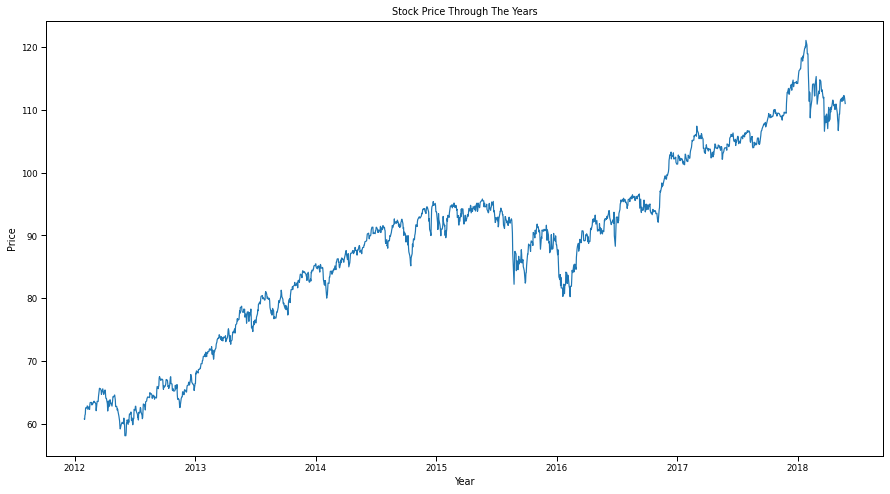

In [51]:
#line plot of stocks price over the years
fig = plt.figure(figsize = (15, 8))
plt.plot(stocks['Price'])
plt.title('Stock Price Through The Years')
plt.ylabel('Price')
plt.xlabel('Year');


---

###### Dot Plot

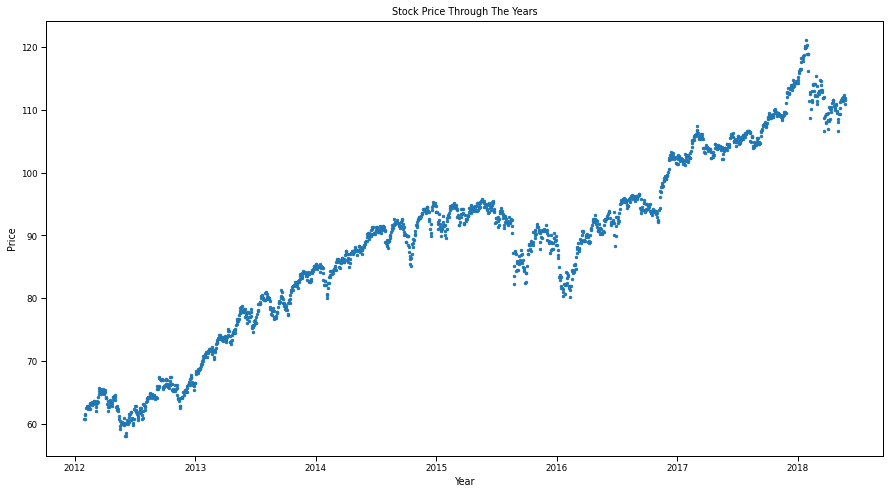

In [52]:
#dot plot of stocks price over the years
fig = plt.figure(2, figsize = (15, 8))
plt.plot(stocks['Price'], '.')
plt.title('Stock Price Through The Years')
plt.ylabel('Price')
plt.xlabel('Year');


---

###### Rolling Statistics

In [53]:
#identify rolling mean and rolling standard deviation
roll_mean = stocks['Price'].rolling(window = 90, center = False).mean()
roll_std = stocks['Price'].rolling(window = 90, center = False).std()

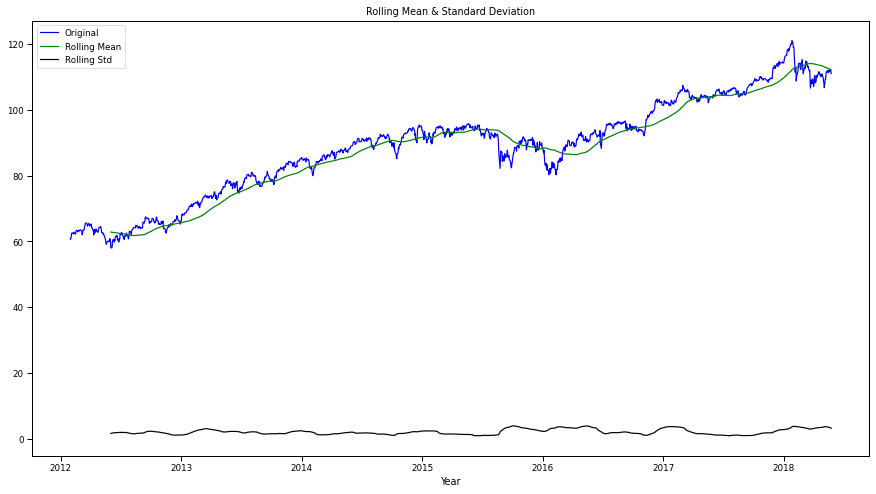

In [54]:
#visualize rolling mean, rolling std, and original
fig = plt.figure(figsize = (15, 8))
plt.plot(stocks['Price'], color = 'blue', label = 'Original')
plt.plot(roll_mean, color = 'green', label = 'Rolling Mean')
plt.plot(roll_std, color = 'black', label = 'Rolling Std')
plt.legend()
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Year')
plt.show()

---

###### The Dickey-Fuller Test

In [55]:
#instantiate adfuller
dftest = adfuller(stocks['Price'])

dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used',
                                           'Number of Observations Used'])
for key, value in dftest[4].items():
  dfoutput['Critical Values (%s)' %key] = value
print(dftest)

(-1.1108320923692123, 0.7107329170108774, 5, 1644, {'1%': -3.4343339050195465, '5%': -2.8632996655963554, '10%': -2.567706805740553}, 3435.1890977612893)


In [56]:
print('Results of Dicky-Fuller test: \n')

print(dfoutput)

Results of Dicky-Fuller test: 

Test Statistic                   -1.110832
p-value                           0.710733
#Lags Used                        5.000000
Number of Observations Used    1644.000000
Critical Values (1%)             -3.434334
Critical Values (5%)             -2.863300
Critical Values (10%)            -2.567707
dtype: float64


**Summary:**
- Not a stationary series
- Linear upward trend
- Slight drop near the end of 2015.


---

###### Histograms

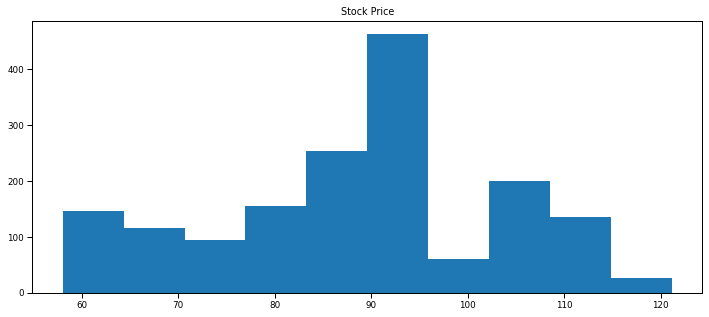

In [57]:
#build histogram to check distribution
fig, ax = plt.subplots(figsize = (12, 5))
ax.hist(stocks['Price'])
ax.set_title('Stock Price')
plt.show()

---

###### Density Plot

Text(0.5, 1.0, 'Density Plot of Stock Price')

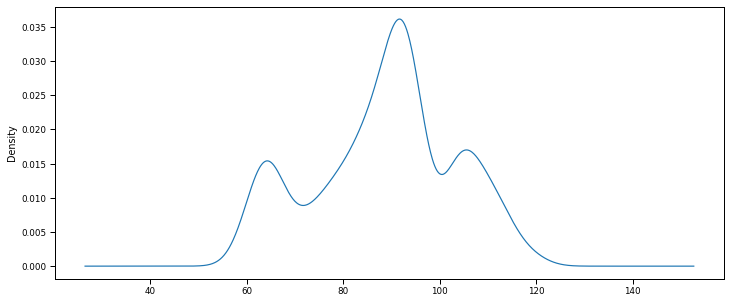

In [58]:
#build density plot to check distribution
stocks['Price'].plot(kind = 'kde', figsize = (12, 5));
ax.set_title('Density Plot of Stock Price')

---

#### Differencing


In [59]:
data = pd.Series(np.sqrt(stocks['Price']))
data_diff = data.diff(periods = 1)
data_diff.head()

Date
2012-01-30         NaN
2012-01-31   -0.004493
2012-02-01    0.042894
2012-02-02    0.008296
2012-02-03    0.066051
Freq: B, Name: Price, dtype: float64

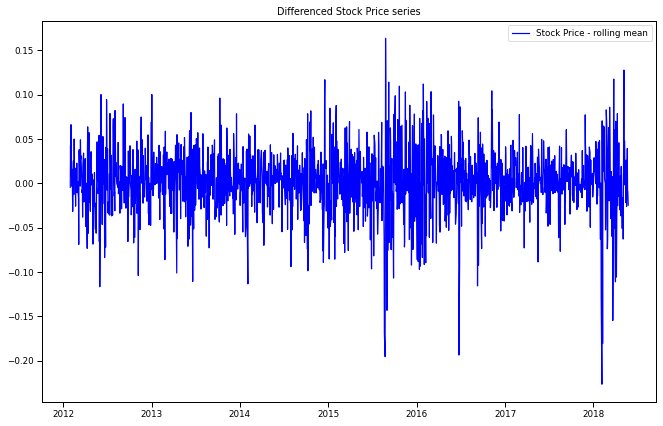

In [60]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_diff, color='blue',label='Stock Price - rolling mean')
plt.legend(loc='best')
plt.title('Differenced Stock Price series')
plt.show(block=False)

In [61]:
data_diff = data.diff().dropna()
data_diff.head()

Date
2012-01-31   -0.004493
2012-02-01    0.042894
2012-02-02    0.008296
2012-02-03    0.066051
2012-02-06   -0.003163
Freq: B, Name: Price, dtype: float64

### News Exploration

<Figure size 1080x576 with 0 Axes>

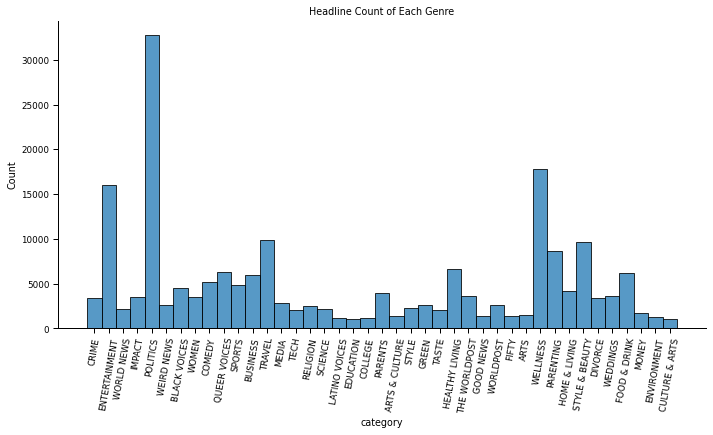

In [62]:
#visualization of headline by genre
fig = plt.figure(figsize = (15, 8))
g = sns.displot(news.category, height = 5, aspect = 2)
g.set_xticklabels(rotation = 80)
plt.title('Headline Count of Each Genre');

---

In [63]:
#separate year from index
news['year'] = news.index.to_series().apply(lambda x: x.year)

In [64]:
news.head()

,category,headline,authors,link,short_description,year
date,,,,,,
2018-05-26,CRIME,2 mass shoot texa last week 1 tv,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018
2018-05-26,ENTERTAINMENT,smith join diplo nicki jam 2018 world cup offi...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018
2018-05-26,ENTERTAINMENT,hugh grant marri first time age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018
2018-05-26,ENTERTAINMENT,jim carrey blast castrato adam schiff democrat...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018
2018-05-26,ENTERTAINMENT,julianna marguli us donald trump poop bag pick...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018


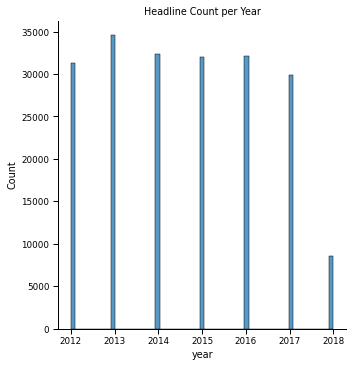

In [65]:
#plot headline count by year
sns.displot(news.year)
plt.title('Headline Count per Year');

---

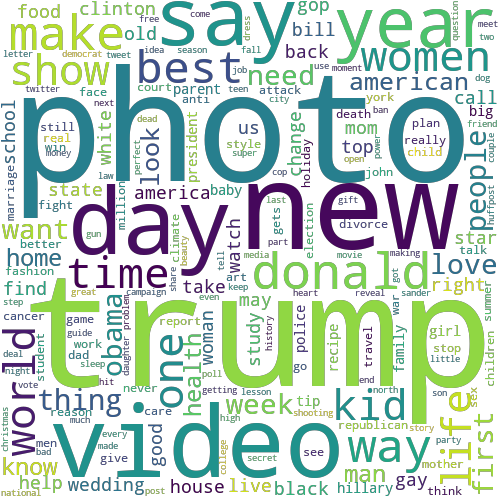

In [66]:
#visualize top words in news dataframe
wc = wordcloud.WordCloud(max_words = 200, width = 500, height = 500, 
                         collocations= False, mode= 'RGBA', 
                         background_color = None)
text = news_tokens
wc.generate_from_text(text);
wc.to_image()

---

In [67]:
most_common = pd.DataFrame(most_common)
most_common.head()

,0,1
0,trump,12996
1,photos,10342
2,new,8574
3,video,5849
4,donald,4607


In [68]:
most_common = most_common.rename(columns = {0: 'word', 1: 'amount'})
most_common.head()

,word,amount
0,trump,12996
1,photos,10342
2,new,8574
3,video,5849
4,donald,4607


In [69]:
most_common.head()

,word,amount
0,trump,12996
1,photos,10342
2,new,8574
3,video,5849
4,donald,4607


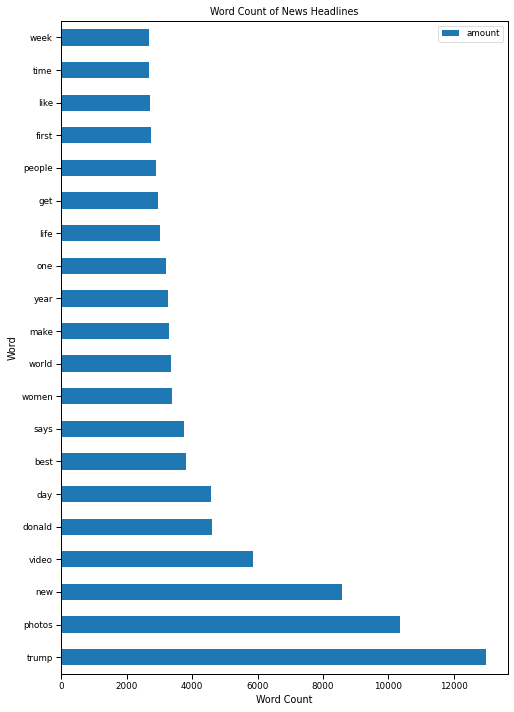

In [70]:
ax = most_common[:20].plot(x = 'word', y = 'amount', kind = 'barh', figsize = (8, 12))
ax.set_title('Word Count of News Headlines')
ax.set_ylabel('Word')
ax.set_xlabel('Word Count');

#Model

## Model 1: Stocks Time Series Models

#### Model 1A: ARMA Model 

In [71]:
data_diff.head()

Date
2012-01-31   -0.004493
2012-02-01    0.042894
2012-02-02    0.008296
2012-02-03    0.066051
2012-02-06   -0.003163
Freq: B, Name: Price, dtype: float64

In [72]:
#set index to be business days
data_diff.index = pd.DatetimeIndex(data_diff.index).to_period('B')

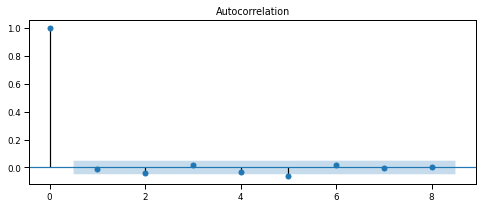

In [73]:
#plotting the ACF
fig, ax = plt.subplots(figsize = (8, 3))

plot_acf(data_diff, ax = ax, lags = 8);

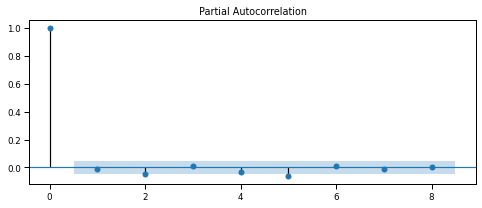

In [74]:
#plotting PACF
fig, ax = plt.subplots(figsize= (8, 3))
plot_pacf(data_diff, ax = ax, lags = 8);

In [75]:
#fit an ARMA 1 model
mod_arma = ARMA(data_diff, order = (1,0))
res_arma = mod_arma.fit()

print(res_arma.summary())

                              ARMA Model Results                              
Dep. Variable:                  Price   No. Observations:                 1649
Model:                     ARMA(1, 0)   Log Likelihood                3107.913
Method:                       css-mle   S.D. of innovations              0.037
Date:                Fri, 04 Dec 2020   AIC                          -6209.826
Time:                        16:57:52   BIC                          -6193.602
Sample:                    01-31-2012   HQIC                         -6203.810
                         - 05-25-2018                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0017      0.001      1.861      0.063   -8.83e-05       0.003
ar.L1.Price    -0.0118      0.025     -0.480      0.631      -0.060       0.036
                                    Roots       

In [76]:
#ARMA 2
mod_arma = ARMA(data_diff, order = (4,3))
res_arma = mod_arma.fit()

print(res_arma.summary())

                              ARMA Model Results                              
Dep. Variable:                  Price   No. Observations:                 1649
Model:                     ARMA(4, 3)   Log Likelihood                3120.235
Method:                       css-mle   S.D. of innovations              0.036
Date:                Fri, 04 Dec 2020   AIC                          -6222.469
Time:                        16:57:56   BIC                          -6173.798
Sample:                    01-31-2012   HQIC                         -6204.423
                         - 05-25-2018                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0017      0.001      3.261      0.001       0.001       0.003
ar.L1.Price     0.0018      0.031      0.059      0.953      -0.060       0.063
ar.L2.Price    -0.0828      0.024     -3.444    

> Attempted higher order numbers but received RunTime errors. Best ARIMA Model has order (4,3)

#### Model 1B: Neural Network 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3093: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


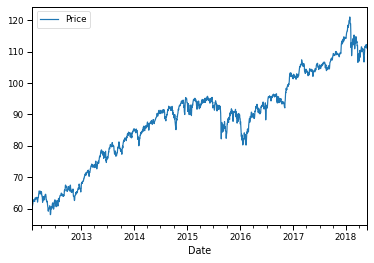

In [77]:
#replace any 0 values
stocks_ts = stocks[['Price']]
stocks_ts[stocks_ts == 0] = np.nan
stocks_ts = stocks_ts.ffill()

#select a shorter time period
stocks_ts = stocks_ts.loc['2012':'2018']
stocks_ts.plot()


In [78]:
stocks_ts

,Price
Date,
2012-01-30,60.73
2012-01-31,60.66
2012-02-01,61.33
2012-02-02,61.46
2012-02-03,62.50
...,...
2018-05-21,112.32
2018-05-22,112.15
2018-05-23,111.96


In [79]:
stocks_ts.index

DatetimeIndex(['2012-01-30', '2012-01-31', '2012-02-01', '2012-02-02',
               '2012-02-03', '2012-02-06', '2012-02-07', '2012-02-08',
               '2012-02-09', '2012-02-10',
               ...
               '2018-05-14', '2018-05-15', '2018-05-16', '2018-05-17',
               '2018-05-18', '2018-05-21', '2018-05-22', '2018-05-23',
               '2018-05-24', '2018-05-25'],
              dtype='datetime64[ns]', name='Date', length=1650, freq='B')

In [80]:
#check for nulls
print('Nulls:', stocks_ts.isna().sum())

#check length of stocks_ts
print('Length of stocks:', len(stocks_ts))

Nulls: Price    0
dtype: int64
Length of stocks: 1650


> *The date of the headline/stock matter, therefore instead of doing the usual train, test, split make sure to follow below steps in your model to keep order.*

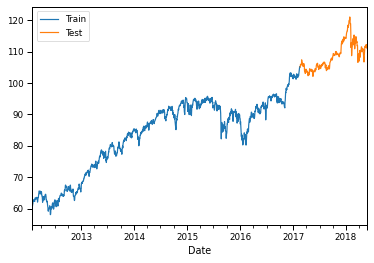

In [81]:
#train test split
int_split = round(len(stocks_ts)*.8) 
train = stocks_ts.iloc[:int_split]
test = stocks_ts.iloc[int_split:]

#visualize
fig, ax = plt.subplots()

train.plot(ax = ax)
test.plot(ax = ax);
L = plt.legend()
L.get_texts()[0].set_text('Train')
L.get_texts()[1].set_text('Test')

In [82]:
#instantiate scaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train) 
X_test = scaler.transform(test) 

X_train

array([[0.05685193],
       [0.05536699],
       [0.06957997],
       ...,
       [0.99957573],
       [0.99745439],
       [1.        ]])

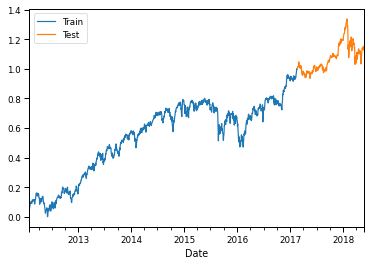

In [83]:
#convert to dataframe
X_train = pd.DataFrame(X_train, index = train.index, columns = ['Price'])
X_test = pd.DataFrame(X_test, index = test.index, columns = ['Price'])

#set frequency to business days
X_train = X_train.asfreq('B')
X_test = X_test.asfreq('B')

#visualize
fig, ax = plt.subplots()
X_train.plot(ax = ax)
X_test.plot(ax = ax)
L = plt.legend()
L.get_texts()[0].set_text('Train')
L.get_texts()[1].set_text('Test')

In [84]:
#set feature number
n_features = X_train.shape[1]

#reshape series
series = X_train.values
series = series.reshape((len(series), n_features))
series

array([[0.05685193],
       [0.05536699],
       [0.06957997],
       ...,
       [0.99957573],
       [0.99745439],
       [1.        ]])

In [85]:
#number of timesteps for the sequences 
length = 50

#create time series generator
generator = TimeseriesGenerator(series, series, length, batch_size = 32)
generator


In [86]:
#testing out ind. output
ex_X, ex_y = generator[1]
ex_X.shape

(32, 50, 1)

In [87]:
#create test data
test_series = X_test.values 
test_series = test_series.reshape((len(test_series), n_features))
test_gen = TimeseriesGenerator(test_series, test_series, length, batch_size = 32)


In [88]:
#define generator
input_shape = (length, n_features)

#number of samples
print('Samples: %d' % len(generator))


Samples: 40


In [89]:
#define model
model = Sequential()
model.add(LSTM(units = 64, activation = 'relu', input_shape = input_shape))
model.add(Dense(1))

model.compile(optimizer= optimizers.Nadam(), loss = 'mse', metrics = ['mse'])

display(model.summary())
history = model.fit(generator, epochs = 20)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


None

Epoch 1/20
40/40 [==============================] - 1s 22ms/step - loss: 0.1018 - mse: 0.1018
Epoch 2/20
40/40 [==============================] - 1s 22ms/step - loss: 0.0041 - mse: 0.0041
Epoch 3/20
40/40 [==============================] - 1s 21ms/step - loss: 0.0029 - mse: 0.0029
Epoch 4/20
40/40 [==============================] - 1s 23ms/step - loss: 0.0022 - mse: 0.0022
Epoch 5/20
40/40 [==============================] - 1s 20ms/step - loss: 0.0021 - mse: 0.0021
Epoch 6/20
40/40 [==============================] - 1s 23ms/step - loss: 0.0012 - mse: 0.0012
Epoch 7/20
40/40 [==============================] - 1s 20ms/step - loss: 9.1276e-04 - mse: 9.1276e-04
Epoch 8/20
40/40 [==============================] - 1s 22ms/step - loss: 0.0013 - mse: 0.0013
Epoch 9/20
40/40 [==============================] - 1s 22ms/step - loss: 0.0011 - mse: 0.0011
Epoch 10/20
40/40 [==============================] - 1s 21ms/step - loss: 0.0011 - mse: 0.0011
Epoch 11/20
40/40 [==============================] 

In [90]:
results = pd.DataFrame(history.history)
results

,loss,mse
0,0.101785,0.101785
1,0.004074,0.004074
2,0.002938,0.002938
3,0.002193,0.002193
4,0.002056,0.002056
5,0.001181,0.001181
6,0.000913,0.000913
7,0.001269,0.001269
8,0.001103,0.001103
9,0.001062,0.001062


In [91]:
y_hat_test = model.predict(test_gen)
y_hat_test.shape

(280, 1)

In [92]:
X_test[length:].shape

(280, 1)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


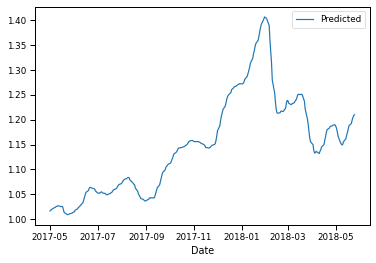

In [93]:
#visualize predicted seperate from trainand test.
sns.lineplot(X_test[length:].index, y_hat_test.flatten(), label = 'Predicted')

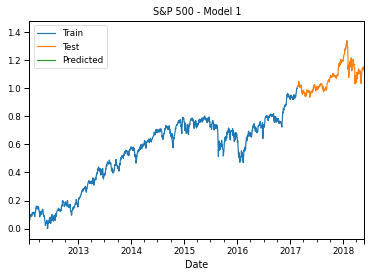

In [94]:
#plot predicted together
fig, ax = plt.subplots()
X_train.plot(ax = ax)
X_test.plot(ax = ax)
ax.plot(X_test[length:].index, y_hat_test.flatten(), label = 'Predicted')
ax.set_title('S&P 500 - Model 1')
L = plt.legend()
L.get_texts()[0].set_text('Train')
L.get_texts()[1].set_text('Test')

#### Model 1C: SARIMA Model

- q - auto regressive part of the model. effect of past values into model. 
- d - amount of differnecing as it identifies the number of lag values to subtract from the current observation
- q - moving average part of the model which is used to set the error of the model as a linear combination of the error values observed at previous time points in the past.

In [95]:
#define p,d,q with value between 0 & 2
p = d = q = range(0, 3)

#generate diff combos of p, q, & d triplets
pdq = list(itertools.product(p, d, q))

#generate all diff combos of seasonal p, d, q, triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

```python
#initialize empty list
answer = []
#iterate through params
for comb in pdq:
  for combs in pdqs:
    try:
      mod = sm.tsa.statespace.SARIMAX(stocks_ts,
                                      order = comb,
                                      seasonal_order = combs,
                                      enforce_stationarity = False, 
                                      enforce_invertibility = False)
      
      output = mod.fit(maxiter = 200)
      answer.append([comb, combs, output.aic])
      print('ARIMA{} x {}12: AIC Calculated = {}'.format(comb, combs, output.aic))
    except:
      continue
```

In [96]:
##UNCOMMENT OUT THIS CELL TO RUN GRID SEARCH
# #initialize empty list
# answer = []
# #iterate through params
# for comb in pdq:
#   for combs in pdqs:
#     try:
#       mod = sm.tsa.statespace.SARIMAX(stocks_ts,
#                                       order = comb,
#                                       seasonal_order = combs,
#                                       enforce_stationarity = False, 
#                                       enforce_invertibility = False)
      
#       output = mod.fit(maxiter = 200)
#       answer.append([comb, combs, output.aic])
#       print('ARIMA{} x {}12: AIC Calculated = {}'.format(comb, combs, output.aic))
#     except:
#       continue
#
# # Find the parameters with minimal AIC value
# ans_df = pd.DataFrame(answer, columns=['pdq', 'pdqs', 'aic'])
# ans_df.loc[ans_df['aic'].idxmin()]

In [97]:
# #plug in optimal parameter values
# arima_model = sm.tsa.statespace.SARIMAX(X_train, 
#                                         order = (2,1,2),
#                                         seasonal_order = (1,1,2,12),
#                                         enforce_stationarity=False,
#                                         enforce_invertibility=False)

# #fit model
# output = arima_model.fit()

# display(output.summary())

In [98]:
#plug in optimal parameter values
arima_model = sm.tsa.statespace.SARIMAX(stocks_ts, 
                                        order = (2,1,2),
                                        seasonal_order = (1,1,2,12),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

#fit model
output = arima_model.fit()

display(output.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Price   No. Observations:                 1650
Model:             SARIMAX(2, 1, 2)x(1, 1, 2, 12)   Log Likelihood               -1718.969
Date:                            Fri, 04 Dec 2020   AIC                           3453.939
Time:                                    16:59:05   BIC                           3497.011
Sample:                                01-30-2012   HQIC                          3469.928
                                     - 05-25-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9560      0.006   -161.088      0.000      -0.968      -0.944
ar.L2         -0.9927      0.005   -181.166      0.000      -1.003      -0.982
ma.L1          0.9613      0.009    104.608      0.000       0.943       0.979
ma.L2          0.9848      0.009    114.226      0.000       0.968       1.002
ar.S.L12      -0.5766      0.407     -1.417      0.156      -1.374       0.221
ma.S.L12      -0.4354      0.412     -1.056      0.291      -1.244       0.373
ma.S.L24      -0.5457      0.409     -1.336      0.182      -1.347       0.255
sigma2         0.4828      0.011     42.781      0.000       0.461       0.505
===================================================================================
Ljung-Box (Q):                       42.72   Jarque-Bera (JB):              1181.75
Prob(Q):                              0.36   Prob(JB):                         0.00
Heteroskedasticity (H):               1.77   Skew:                            -0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

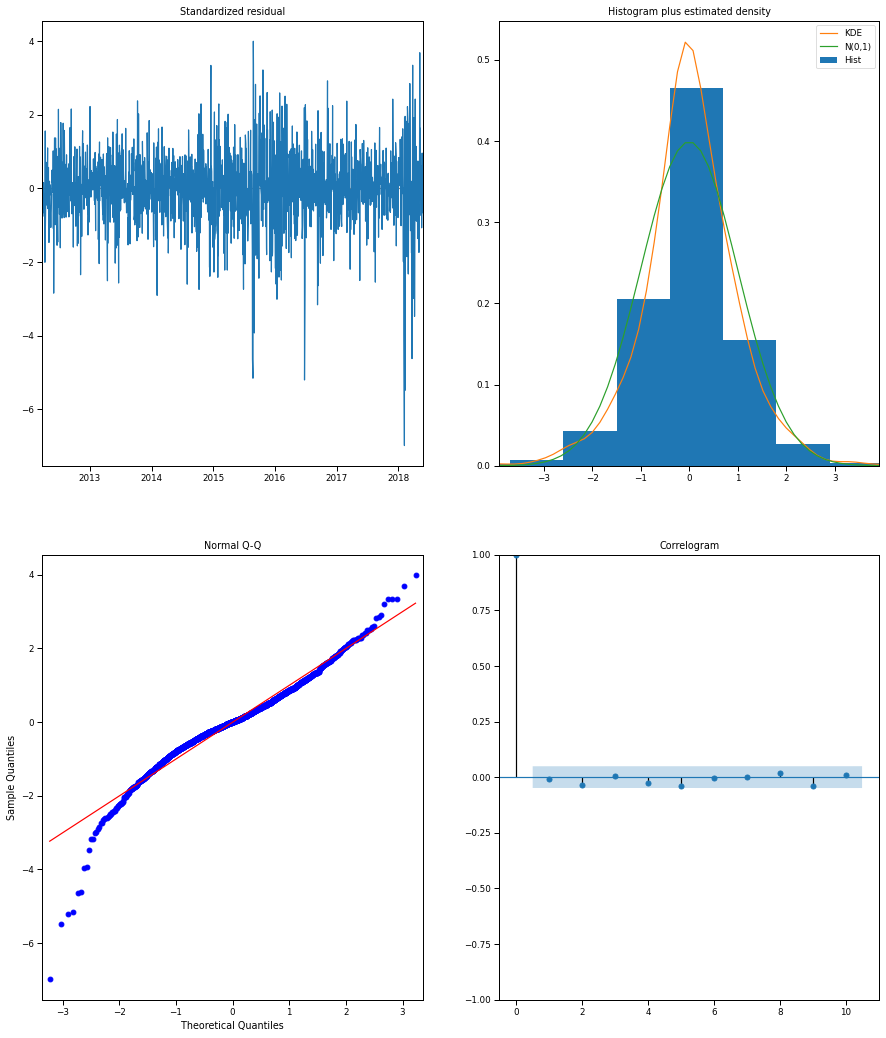

In [99]:
output.plot_diagnostics(figsize = (15, 18))
plt.show()

###### Validating the SARIMA Model

In [100]:
res = arima_model.filter(output.params)

In [101]:
# #get predictions: dynamic is False
# pred = output.get_forecast(len(X_test), 
#                              dynamic = False)
# pred_conf = pred.conf_int()


# pred_conf['mean'] = pred.predicted_mean
# pred_conf.index = X_test.index

# pred_conf

In [102]:
#get predictions, dynamic = False
#have it start at first day in test set
pred_dynamic = output.get_prediction(dynamic = False)
pred_conf_dynamic = pred_dynamic.conf_int()

#calculate mean
pred_conf_dynamic['mean'] = pred_dynamic.predicted_mean

pred_conf_dynamic

,lower Price,upper Price,mean
Date,,,
2012-01-30,-3394.757202,3394.757202,0.000000
2012-01-31,-3124.617333,3207.371774,41.377220
2012-02-01,-3110.197509,3214.939736,52.371114
2012-02-02,-3249.020553,3394.161955,72.570701
2012-02-03,-3238.287609,3355.557844,58.635117
...,...,...,...
2018-05-21,110.293838,113.018792,111.656315
2018-05-22,110.776183,113.501136,112.138660
2018-05-23,110.795950,113.520903,112.158427


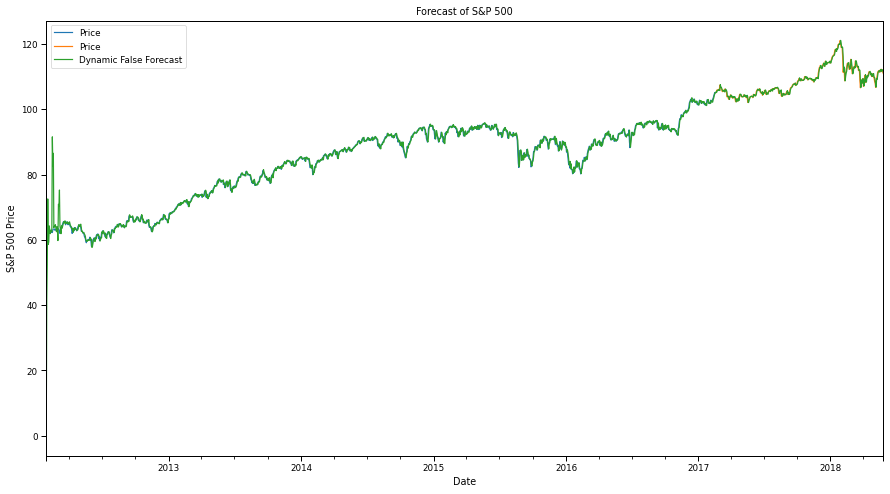

In [105]:
#Dynamic = False Visualization
ax = train.plot(label = 'Observed', figsize = (15, 8))
test.plot(ax =ax, label = 'Test')
pred_conf_dynamic['mean'].plot(label = 'Dynamic False Forecast', ax = ax)

# ax.fill_between(pred_conf_dynamic.index,
#                  pred_conf_dynamic.iloc[:, 0],
#                  pred_conf_dynamic.iloc[:, 1], color='g', alpha=.3)

ax.set_xlabel('Date')
ax.set_ylabel('S&P 500 Price')
ax.set_title('Forecast of S&P 500')

ax.legend()
plt.show()

In [106]:
# #Dynamic = False Visualization
# ax = X_train.plot(label = 'Observed', figsize = (15, 8))
# X_test.plot(ax =ax, label = 'Test')
# pred_conf['mean'].plot(label = 'Dynamic Forecast', ax = ax)

# ax.fill_between(pred_conf.index,
#                  pred_conf.iloc[:, 0],
#                  pred_conf.iloc[:, 1], color='g', alpha=.3)

# ax.set_xlabel('Date')
# ax.set_ylabel('S&P 500 Price')
# ax.set_title('Forecast of S&P 500')

# ax.legend()
# plt.show()

In [108]:
#real and predicted values
stocks_forecasted = pred.predicted_mean.values
stocks_truth = stocks_ts['2017-06-02':].values

#compute mse
mse = ((stocks_forecasted - stocks_truth) ** 2).mean()
print('MSE is {}'.format(round(mse, 2)))

NameError: ignored

In [109]:
# #Dynamic = True Visualization
# ax = X_train.plot(label = 'Observed', figsize = (15, 8))
# X_test.plot(ax =ax, label = 'Test')
# pred_conf_dynamic['mean'].plot(label = 'Dynamic True Forecast', ax = ax)

# ax.fill_between(pred_conf_dynamic.index,
#                  pred_conf_dynamic.iloc[:, 0],
#                  pred_conf_dynamic.iloc[:, 1], color='g', alpha=.3)

# ax.set_xlabel('Date')
# ax.set_ylabel('S&P 500 Price')
# ax.set_title('Dynamic Forecast of S&P 500')


# ax.legend()
# plt.show()

In [110]:
# #real and predicted values
# stocks_forecasted = pred_dynamic.predicted_mean.values
# stocks_truth = stocks_ts['2017-06-02':].values

# #compute mse
# mse = ((stocks_forecasted - stocks_truth) ** 2).mean()
# print('MSE is {}'.format(round(mse, 2)))

**Observation**: Both graphs had the same mse and numbers showing there is no difference between dynamic and not.

## Model 2: What words cause the stock market to increase?


##### **Step 1** : Calculate the change in stocks between each day and set as target.

In [111]:
#identify daily differences and save as new column
stocks_ts['daily_change'] = stocks_ts.diff(periods=1)
stocks_ts.head()

,Price,daily_change
Date,,
2012-01-30,60.73,NaN
2012-01-31,60.66,-0.07
2012-02-01,61.33,0.67
2012-02-02,61.46,0.13
2012-02-03,62.50,1.04


In [112]:
#identify if daily change was +/-
new_list = []

for i in stocks_ts['daily_change']:
  if i < 0:
    i = 0
  else:
    i= 1
  new_list.append(i)

**For Record**:
- 0 = negative integer 
- 1 = positive integer

In [113]:
#create new column with pos/neg words
stocks_ts['movement'] = new_list
stocks_ts.head()

,Price,daily_change,movement
Date,,,
2012-01-30,60.73,NaN,1
2012-01-31,60.66,-0.07,0
2012-02-01,61.33,0.67,1
2012-02-02,61.46,0.13,1
2012-02-03,62.50,1.04,1


---

##### **Step 2**: Join together news headlines by day

In [114]:
news.head()

,category,headline,authors,link,short_description,year
date,,,,,,
2018-05-26,CRIME,2 mass shoot texa last week 1 tv,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018
2018-05-26,ENTERTAINMENT,smith join diplo nicki jam 2018 world cup offi...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018
2018-05-26,ENTERTAINMENT,hugh grant marri first time age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018
2018-05-26,ENTERTAINMENT,jim carrey blast castrato adam schiff democrat...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018
2018-05-26,ENTERTAINMENT,julianna marguli us donald trump poop bag pick...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018


In [115]:
#groupby index date
b = news.groupby(news.index)
b.head(3)

,category,headline,authors,link,short_description,year
date,,,,,,
2018-05-26,CRIME,2 mass shoot texa last week 1 tv,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018
2018-05-26,ENTERTAINMENT,smith join diplo nicki jam 2018 world cup offi...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018
2018-05-26,ENTERTAINMENT,hugh grant marri first time age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018
2018-05-25,WORLD NEWS,north korea still open talk trump cancel summit,"Josh Smith and Christine Kim, Reuters",https://www.huffingtonpost.com/entry/north-kor...,Trump’s announcement came after repeated threa...,2018
2018-05-25,WORLD NEWS,2 men deton bomb insid indian restaur near tor...,,https://www.huffingtonpost.com/entry/mississau...,"Fifteen people were taken to the hospital, thr...",2018
...,...,...,...,...,...,...
2012-01-29,TRAVEL,travel roar twenti photo,"Black Tomato, Contributor\nCutting-edge travel...",https://www.huffingtonpost.com/entry/1920s-rev...,The fashion and film world is sticking a few j...,2012
2012-01-29,STYLE & BEAUTY,schick launch hydro silk razor review,,https://www.huffingtonpost.comhttp://www.bella...,From BellaSugar: Hydro Silk is Schick's first ...,2012
2012-01-28,HOME & LIVING,diy idea 9 project enhanc home weekend,Diana N. Nguyen,https://www.huffingtonpost.com/entry/diy-ideas...,Looking to update and refresh your home with s...,2012


In [116]:
#aggregate headlines based on groups
news2 = b.agg({'headline': ' '.join})
news2.head()

,headline
date,
2012-01-28,diy idea 9 project enhanc home weekend ikea sh...
2012-01-29,healthi super bowl recip travel roar twenti ph...
2012-01-30,jessica hopp blogger behind becom girl show ba...
2012-01-31,miley cyru mom jean might actual kinda cute vi...
2012-02-01,astrolog relationship project come head man dr...


In [117]:
#check day 1
news2.headline[0]

'diy idea 9 project enhanc home weekend ikea shop best item buy onlin friend like icon day search lost time salon tea confess pediatrician sleep softi yoga journal 21 day challeng day 20 sidebend jason crandel video camila alv style evolut photo taco bell first meal fast food breakfast offend blazer find centuri network design inspir franci ford coppola bernalda hotel wall street journal magazin shovel snow protect back heart 1 girl 4 look meet nyc hottest new model lili kwong 7 reason work much bad health sleep librari 11 sooth book bedtim carolin sieber lauren santo domingo loui vuitton look day photo benefit care pet fenc tea time beneath western ghat photo begin surpris advic centenarian cheryl tieg sauna look back teen respons happen nurtur studi find conserv moron jon stewart dead kennedi fan 80 photo appar show young daili show host punk show updat ok probabl tim eric billion dollar movi pledg sign paul rudd ben stiller video best late night clip week video photo daili show corr

---

##### **Step 3**: Offset News Headlines


In [118]:
news2.head()

,headline
date,
2012-01-28,diy idea 9 project enhanc home weekend ikea sh...
2012-01-29,healthi super bowl recip travel roar twenti ph...
2012-01-30,jessica hopp blogger behind becom girl show ba...
2012-01-31,miley cyru mom jean might actual kinda cute vi...
2012-02-01,astrolog relationship project come head man dr...


>**Explanation**: Below I am using the shift method to move all of the headline rows up one in order to correspond with the date before. By doing this I can use the headlines from the day before in order to see if the stock market is increasing or decreasing.

In [119]:
#offset using shift method
news2 = news2.shift(periods = -1)
news2.head(10)

,headline
date,
2012-01-28,healthi super bowl recip travel roar twenti ph...
2012-01-29,jessica hopp blogger behind becom girl show ba...
2012-01-30,miley cyru mom jean might actual kinda cute vi...
2012-01-31,astrolog relationship project come head man dr...
2012-02-01,join eckhart toll jim carrey john raatz rais c...
2012-02-02,one two three begin achiev dream right break f...
2012-02-03,quick healthi recip 52 meal 12 minut le five r...
2012-02-04,kelli osbourn gray hair someth want whole life...
2012-02-05,cailliann samantha chloe beckerman beckerman b...


In [120]:
#resample to business days
news2 = news2.resample('B').last()
news2.head(10)

,headline
date,
2012-01-27,jessica hopp blogger behind becom girl show ba...
2012-01-30,miley cyru mom jean might actual kinda cute vi...
2012-01-31,astrolog relationship project come head man dr...
2012-02-01,join eckhart toll jim carrey john raatz rais c...
2012-02-02,one two three begin achiev dream right break f...
2012-02-03,cailliann samantha chloe beckerman beckerman b...
2012-02-06,victoria harper beckham match plaid photo mich...
2012-02-07,divorc help second marriag good bad beauti run...
2012-02-08,skip prix fix serious romant swap stylish abod...


In [121]:
news2.isna().sum()


headline    0
dtype: int64

In [122]:
news2.headline[0]

'jessica hopp blogger behind becom girl show babi pictur parti photo indiana welcom super bowl fan child postcard photo afraid travel disarm medium hype water park miami huffington post travel guid 10 dip nibbl dish game day isabella rossellini model betsey johnson 1995 look back small town life peruvian and self accept alchemist leopard build fit habit 21 day 5 place meet bear b c 9 korean recip go outsid comfort zone q10 carol woolton forbid daughter visit friend dad home met plane new websit reconnect flyer forget exchang number today show learn absurd men groom fashion word video david beckham h underwear commerci everyth hope video spare rod caus kid riot stylelist staff bought weekend januari 28th 29th photo worri total drug resist tuberculosi weight loss success mark rucker made small chang lost 100 pound help want ihpc stakehold report detail integr medicin opportun afford care act declin digniti 5 way use leftov bread finger gay wed ring new discoveri spa bar pool suit photo s

##### **Step 4**: Merge Tables and Prepare Data for Model

In [123]:
#reset index of news
news2.reset_index(inplace = True)
news2.head()

,date,headline
0,2012-01-27,jessica hopp blogger behind becom girl show ba...
1,2012-01-30,miley cyru mom jean might actual kinda cute vi...
2,2012-01-31,astrolog relationship project come head man dr...
3,2012-02-01,join eckhart toll jim carrey john raatz rais c...
4,2012-02-02,one two three begin achiev dream right break f...


In [124]:
#reset index of stocks_ts
stocks_ts.reset_index(inplace = True)
stocks_ts.head()

,Date,Price,daily_change,movement
0,2012-01-30,60.73,NaN,1
1,2012-01-31,60.66,-0.07,0
2,2012-02-01,61.33,0.67,1
3,2012-02-02,61.46,0.13,1
4,2012-02-03,62.50,1.04,1


In [125]:
#rename date column to match news df
stocks_ts = stocks_ts.rename(columns = {'Date': 'date'})
stocks_ts.head()

,date,Price,daily_change,movement
0,2012-01-30,60.73,NaN,1
1,2012-01-31,60.66,-0.07,0
2,2012-02-01,61.33,0.67,1
3,2012-02-02,61.46,0.13,1
4,2012-02-03,62.50,1.04,1


In [126]:
pysqldf = lambda q: sqldf(q, globals())

In [127]:
#join news and stock_ts dataframes
q = '''SELECT s.date, s.movement,  n.headline, s.Price, s.daily_change
                FROM stocks_ts s
                JOIN news2 n
                ON n.date = s.date;'''
df = pysqldf(q)
df.head()

,date,movement,headline,Price,daily_change
0,2012-01-30 00:00:00.000000,1,miley cyru mom jean might actual kinda cute vi...,60.73,NaN
1,2012-01-31 00:00:00.000000,0,astrolog relationship project come head man dr...,60.66,-0.07
2,2012-02-01 00:00:00.000000,1,join eckhart toll jim carrey john raatz rais c...,61.33,0.67
3,2012-02-02 00:00:00.000000,1,one two three begin achiev dream right break f...,61.46,0.13
4,2012-02-03 00:00:00.000000,1,cailliann samantha chloe beckerman beckerman b...,62.50,1.04


In [128]:
#set index to date
df.date = pd.to_datetime(df.date)
df = df.set_index('date')
df.head()

,movement,headline,Price,daily_change
date,,,,
2012-01-30,1,miley cyru mom jean might actual kinda cute vi...,60.73,NaN
2012-01-31,0,astrolog relationship project come head man dr...,60.66,-0.07
2012-02-01,1,join eckhart toll jim carrey john raatz rais c...,61.33,0.67
2012-02-02,1,one two three begin achiev dream right break f...,61.46,0.13
2012-02-03,1,cailliann samantha chloe beckerman beckerman b...,62.50,1.04


In [129]:
df.headline[0]

'miley cyru mom jean might actual kinda cute video poll marion cotillard carey mulligan vaniti fair get u 20 mood photo 12 reason avoid gmo king karl healthi mexican home frito pie makeov u panel defend call censor bird flu studi william kate patter littl foot cocker spaniel militari famili autism recip heartach chef love yotam ottolenghi kerri washington birthday actress turn 35 style evolut photo 3 way make sleep tsa supervisor wait hour report possibl pipe bomb wood shop hau interior david stark nina freudenberg photo 5 support app breastfeed mama linda evangelista love magazin cover total mod photo alison sweeney biggest loser host dog winki battl pet obes 5 tip recent marri divorc taxpay name chang brad pitt say let kid googl angelina joli 5 new us babi powder vaniti fair nod 20 trend rachel roy footwear style news 6 click turn 50 demi moor figur matter tv ill advis wed super bowl import anyth american coupl argu togeth stay togeth bicker could key long healthi marriag candic swan

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


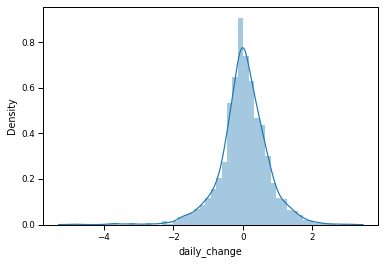

In [130]:
sns.distplot(df.daily_change)

In [131]:
df.shape

(1650, 4)

In [132]:
#elminate anything between -0.5 and 0.5
df = df.loc[(df.daily_change < -.05) | (df.daily_change > 0.05)]
df

,movement,headline,Price,daily_change
date,,,,
2012-01-31,0,astrolog relationship project come head man dr...,60.66,-0.07
2012-02-01,1,join eckhart toll jim carrey john raatz rais c...,61.33,0.67
2012-02-02,1,one two three begin achiev dream right break f...,61.46,0.13
2012-02-03,1,cailliann samantha chloe beckerman beckerman b...,62.50,1.04
2012-02-07,1,divorc help second marriag good bad beauti run...,62.56,0.11
...,...,...,...,...
2018-05-21,1,australian archbishop convict cover child sex ...,112.32,0.83
2018-05-22,0,trump american far right stoke hate canada far...,112.15,-0.17
2018-05-23,0,north korea threaten call trump summit warn nu...,111.96,-0.19


> For better performance I decided to drop any daily_change over or under .05

##### **Step 5**: Train, Test, Split

In [133]:
#Set X and y
X = df['headline']
y = df.movement

#train_test_split
int_split = round(len(X)*.8) 
X_train = X.iloc[:int_split]
X_test = X.iloc[int_split:]

y_train = y.iloc[:int_split]
y_test = y.iloc[int_split:]

In [134]:
print('y_train:')
print(y_train.value_counts(normalize = True))
print(y_train.shape)
print('---' * 5)
print('y_test:')
print(y_test.value_counts(normalize = True))
y_test.shape

y_train:
1    0.534188
0    0.465812
Name: movement, dtype: float64
(1170,)
---------------
y_test:
1    0.534247
0    0.465753
Name: movement, dtype: float64


(292,)

In [135]:
#instantiate lb
lb = LabelBinarizer()

#apply to train and test
y_train = lb.fit_transform(y_train)
y_train

y_test = lb.transform(y_test)
y_test[:10]

array([[1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1]])

##### **Step 6**: Tokenize and Pad News Headlines

In [136]:
#assign max
max_words = 3000
max_sequence_length = 839

In [137]:
#tokenize and pad X_train
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(X_train) 
sequences = tokenizer.texts_to_sequences(X_train)
X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(
    sequences, maxlen = max_sequence_length)
print(X_train_padded)


[[   0    0    0 ...  457 1045  157]
 [   0    0    0 ...  165  334   83]
 [   0    0    0 ...  445 2799    4]
 ...
 [   0    0    0 ...  609  355  230]
 [   0    0    0 ... 1613  294  375]
 [   0    0    0 ... 2458  475 1162]]


In [138]:
print("X_train_padded shape:", X_train_padded.shape)
print("y_train shape:", y_train.shape)

X_train_padded shape: (1170, 839)
y_train shape: (1170, 1)


In [139]:
#tokenize X
X_sequences = tokenizer.texts_to_sequences(X)
X_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    X_sequences, maxlen = max_sequence_length)
print(X_sequences)

[[   0    0    0 ...  457 1045  157]
 [   0    0    0 ...  165  334   83]
 [   0    0    0 ...  445 2799    4]
 ...
 [   0    0    0 ...  171  954  476]
 [   0    0    0 ... 1056 1853  390]
 [   0    0    0 ...  791  459  364]]


In [140]:
#tokenize and pad X_test
sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(
    sequences,  maxlen = max_sequence_length)
print(X_test_padded)


[[   0    0    0 ...  153  978   64]
 [   0    0    0 ... 1928 1125   55]
 [   0    0    0 ...  231  381  526]
 ...
 [   0    0    0 ...  171  954  476]
 [   0    0    0 ... 1056 1853  390]
 [   0    0    0 ...  791  459  364]]


In [141]:
print("X_test_padded shape:", X_test_padded.shape)
print("y_test shape:", y_test.shape)

X_test_padded shape: (292, 839)
y_test shape: (292, 1)


##### **Model 2A**: LSTM Neural Network

In [142]:
#assign precision and recall
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

In [143]:
# Set callback to control run time
callback = tf.keras.callbacks.EarlyStopping(monitor = 'acc', min_delta = 0.01, 
                                            patience = 4, verbose =1, 
                                            restore_best_weights = True)



In [144]:
#check for weights
pd.Series(y_train.flatten()).value_counts(1)

1    0.534188
0    0.465812
dtype: float64

In [145]:
# from keras.utils.generic_utils import get_custom_objects
# from keras import backend as K
# from keras.layers import Activation

# def custom_activation(x, beta = 1):
#         return (K.sigmoid(beta * x) * x)

# get_custom_objects().update({'custom_activation': Activation(custom_activation)})

In [146]:
# model.add(Activation(custom_activation,name = "Swish"))

**Improvement ideas tried**: 
- *Optimizers*: RMSPROP, AdaDelta, Nadam, Adam
- *Activation*: tanh, sigmoid, relu, swish
- Adding Dense layers (one layer)
- Different drop out rates
- Switching between l1 and l2 reg with diff #'s (l1 or using both is best l1_l2)
- Adding additional LSTM
- Val split .2, .1, .17
- Switching unit size and batch size


In [147]:
np.unique(y_train)

array([0, 1])

In [148]:
from sklearn.utils.class_weight import compute_class_weight
class_weight = compute_class_weight('balanced', [0,1], y_train.flatten())
class_weight = dict(zip([0,1], class_weight))
class_weight

{0: 1.073394495412844, 1: 0.936}

Add markdown explaining class_weight here.

In [149]:
model = Sequential()
model.add(Embedding(max_words, 300)) #can change 100 for how many datapts 
model.add(LSTM(64, activation = 'relu', return_sequences=True,
               kernel_regularizer=regularizers.l1(0.001)))

model.add(Dropout(0.3))
model.add(LSTM(32, activation = 'relu', return_sequences=False,
               kernel_regularizer=regularizers.l1(0.001)))
model.add(Dropout(0.5))
model.add(Dense(32, activation = 'relu', 
                kernel_regularizer=regularizers.l1(0.001)))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer= optimizers.Adam(), loss = 'binary_crossentropy', 
              metrics = ['acc', precision, recall])

#display(model.summary())
history = model.fit(X_train_padded, y_train, batch_size = 32, epochs = 8,
                    callbacks = callback, validation_split = .1, 
                    class_weight = class_weight)

Epoch 1/8
33/33 [==============================] - 39s 1s/step - loss: 4.3304 - acc: 0.5233 - precision: 0.5365 - recall: 0.8085 - val_loss: 3.1749 - val_acc: 0.5470 - val_precision: 0.5645 - val_recall: 0.5738
Epoch 2/8
33/33 [==============================] - 38s 1s/step - loss: 2.3621 - acc: 0.5062 - precision: 0.5373 - recall: 0.5621 - val_loss: 1.6392 - val_acc: 0.5214 - val_precision: 0.5214 - val_recall: 1.0000
Epoch 3/8
33/33 [==============================] - 38s 1s/step - loss: 1.2375 - acc: 0.5347 - precision: 0.5354 - recall: 0.9929 - val_loss: 0.9554 - val_acc: 0.5214 - val_precision: 0.5214 - val_recall: 1.0000
Epoch 4/8
33/33 [==============================] - 38s 1s/step - loss: 0.8741 - acc: 0.5356 - precision: 0.5356 - recall: 1.0000 - val_loss: 0.8063 - val_acc: 0.5214 - val_precision: 0.5214 - val_recall: 1.0000
Epoch 5/8
33/33 [==============================] - 38s 1s/step - loss: 0.7702 - acc: 0.4672 - precision: 0.5025 - recall: 0.5248 - val_loss: 0.7423 - val_ac

In [150]:
def model_visuals(model, X_test, y_test):
  '''model_visuals is used to create a classification report, confusion matrix, 
  and visualize loss, accuracy, precision, and recall.

  Args: 
  model = model created
  X_test = X_test
  y_test = y_test

  Returns:
  Classification Report
  Confusion Matrix
  Visual of loss
  Visual of accuracy
  Visual of precision
  Visual of recall

  Example:
  model_visuals(model1, X_test, y_test)'''
  
  y_hat_test = model.predict(X_test).round()
  
  results_df = pd.DataFrame(history.history)
  
  #classification report
  print('CLASSIFICATION REPORT')
  print('---' * 20)
  print(classification_report(y_test, y_hat_test, target_names
                                = ["Negative", "Postive"]))
    
  print('---' * 20)

  #Confusion Matrix
  print("CONFUSION MATRIX")
  cm = confusion_matrix(y_test, y_hat_test, normalize = 'true')

  ax = sns.heatmap(cm, cmap = 'Blues', annot = True)
  ax.set_xticklabels(["Negative", "Postive"])
  ax.set_yticklabels(["Negative", "Postive"]);

  print('---' * 20)

  # visualizing loss
  ax1 = results_df[[col for col in results_df.columns if 'loss' in col]].plot(marker='+')
  ax1.set(xlabel = 'Epoch', ylabel = 'Mean Squared Error', title = 'LOSS VISUALIZATION');

  # visualizing accuracy
  ax2 = results_df[[col for col in results_df.columns if 'acc' in col]].plot(marker='+')
  ax2.set(xlabel = 'Epoch', ylabel ='Accuracy', title = 'ACCURACY VISUALIZATION');

  #visualizing precision
  ax2 = results_df[[col for col in results_df.columns if 'precision' in col]].plot(marker='+')
  ax2.set(xlabel = 'Epoch', ylabel ='Precision', title = 'PRECISION VISUALIZATION');

  #visualizing recall
  ax2 = results_df[[col for col in results_df.columns if 'recall' in col]].plot(marker='+')
  ax2.set(xlabel = 'Epoch', ylabel ='Recall', title = 'RECALL VISUALIZATION');

In [151]:
y_hat_test = model.predict(X_test_padded).round()
y_hat_test[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [152]:
testing = model.predict(X_train_padded).round()
testing

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [153]:
np.unique(testing)

array([1.], dtype=float32)

CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       136
     Postive       0.53      1.00      0.70       156

    accuracy                           0.53       292
   macro avg       0.27      0.50      0.35       292
weighted avg       0.29      0.53      0.37       292

------------------------------------------------------------
CONFUSION MATRIX
------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


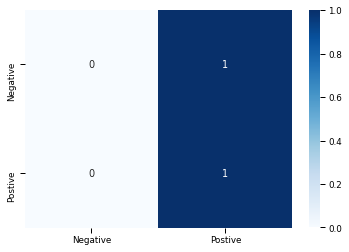

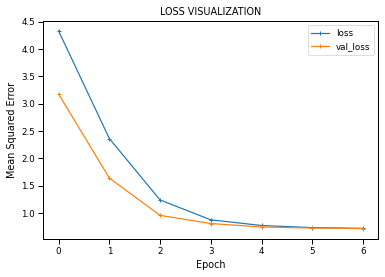

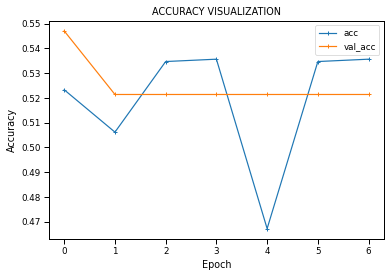

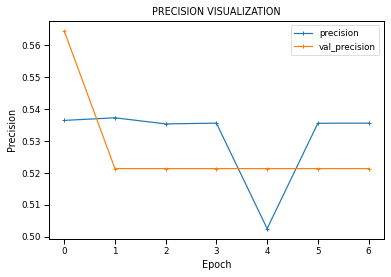

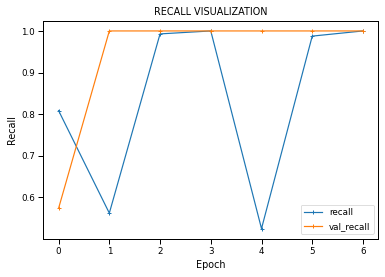

In [154]:
model_visuals(model, X_test_padded, y_test)


##### **Model 2B**: Random Forest Model



In [155]:
count_vect = CountVectorizer()
#X_train
X_train_counts = count_vect.fit_transform(X_train)
print(X_train_counts.shape)
#X_test
X_test_counts = count_vect.transform(X_test)
X_test_counts.shape

(1170, 29669)


(292, 29669)

In [156]:
X_train

date
2012-01-31    astrolog relationship project come head man dr...
2012-02-01    join eckhart toll jim carrey john raatz rais c...
2012-02-02    one two three begin achiev dream right break f...
2012-02-03    cailliann samantha chloe beckerman beckerman b...
2012-02-07    divorc help second marriag good bad beauti run...
                                    ...                        
2017-02-01    trump defens chief matti u stand shoulder shou...
2017-02-03    conserv chines new year parad super queer year...
2017-02-06    littl boy give away toy special lemonad stand ...
2017-02-07    eva longoria realli good director woman stephe...
2017-02-09    congression oversight may import ever jason ch...
Name: headline, Length: 1170, dtype: object

In [157]:
tf_transformer = TfidfVectorizer()
#X_train
X_train_tf = tf_transformer.fit_transform(X_train)
print(X_train_tf.shape)
X_train_tf = pd.DataFrame(X_train_tf.todense(), columns = tf_transformer.get_feature_names())
#X_test
X_test_tf = tf_transformer.transform(X_test)
X_test_tf = pd.DataFrame(X_test_tf.todense(), columns = tf_transformer.get_feature_names())
X_test_tf.shape

(1170, 29669)


(292, 29669)

In [158]:
X_test_tf

,00,000,00064,000th,001,002,007,012,013,014,019,02,03,04,0445,069,07,08,080,10,100,1000,100k,100m,100th,101,1012,102,103,103rd,104,1040,105,105th,106,107,108,109,10a,10k,...,zoobean,zoodl,zooey,zookeep,zooland,zoom,zoonosi,zootopia,zorek,zorro,zosia,zottman,zsa,zubchevich,zucchini,zucker,zuckerberg,zuckerman,zuill,zukav,zulu,zumba,zuni,zuniga,zurich,zurlon,zwirner,zyberk,zylowska,zymurgi,zyola,zytiga,zz,zzz,ça,édgar,émigré,émilion,étienn,čechomor
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008657,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.035158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010739,0.019866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.044068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
288,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
289,0.0,0.019410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
290,0.0,0.028082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [159]:
#instantiate Random Forest Classifier
clf = RandomForestClassifier(random_state = 1212)
clf.fit(X_train_tf, y_train.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1212,
                       verbose=0, warm_start=False)

In [160]:
#set param grid
clf_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}

In [161]:
# clf_grid_search = GridSearchCV(clf, clf_param_grid, cv = 3)

# clf_grid_search.fit(X_train_tf, y_train.ravel())
# print('Best Params:', clf_grid_search.best_params_)

In [162]:
#insert best parameters from above
clf = RandomForestClassifier(random_state = 1212, criterion= 'gini', 
                             max_depth= 1, min_samples_leaf= 1, 
                             min_samples_split= 2 )
clf.fit(X_train_tf, y_train.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1212,
                       verbose=0, warm_start=False)

In [163]:
y_pred = clf.predict(X_test_tf)

In [164]:
def clf_model_information(clf, X_train, X_test, y_test, y_train):
    ''' Model information is used to create a classification report, confusion 
    matrix, roc curve, and when needed a feature importance visualization. 
    
    Args:
    clf = model used
    X_train = X_train
    X_test = X_test
    y_test = y_test
    y_train = y_train

    Returns:
    Classification report
    Confusion Matrix
    Roc Curve
    Feature Importance

    Example:
    clf_model_information(clf, X_train_tf, X_test_tf, y_test.ravel(), y_train.ravel())
    '''

    clf.fit(X_train, y_train)
    predict = clf.predict(X_test)
    print("Testing Accuracy for Classifier: {:.4}%".format(
    accuracy_score(y_test, predict) * 100));
    print('---' * 20)

    #classification report
    print('CLASSIFICATION REPORT')
    print('---' * 20)
    print(classification_report(y_test, predict, target_names
                                = ["Negative", "Positive"]));
    
    print('---' * 20)
    
    with plt.style.context('seaborn-notebook'):
        fig, axes = plt.subplots(figsize = (8,8), nrows = 2)
        sns.set_palette("Blues")
        #confusion matrix
    conf = plot_confusion_matrix(clf, X_test, y_test, cmap = plt.cm.Blues, 
                                    display_labels = ["Negative", "Positive"], ax=axes[0],
                                    normalize = 'true');
    conf.ax_.set_title('CONFUSION MATRIX');

  #roc curve
    plot_roc_curve(clf, X_test, y_test, ax = axes[1])
    plt.show()
        #adding feature importance 
    try:
        print('---' *20)
            #print('FEATURE IMPORTANCE')
            #feature importance
        feat_import = pd.Series(clf.feature_importances_,index= X_train.columns)
        feat_import.sort_values().tail(20).plot(kind='bar').set_title('FEATURE IMPORTANCE')
    except Exception as e:
      print(e)


Testing Accuracy for Classifier: 53.42%
------------------------------------------------------------
CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       136
    Positive       0.53      1.00      0.70       156

    accuracy                           0.53       292
   macro avg       0.27      0.50      0.35       292
weighted avg       0.29      0.53      0.37       292

------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


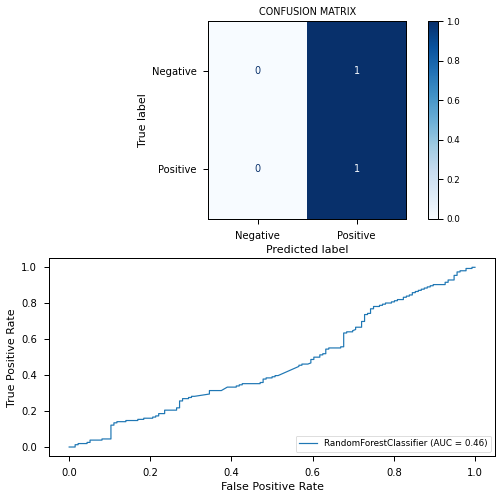

------------------------------------------------------------


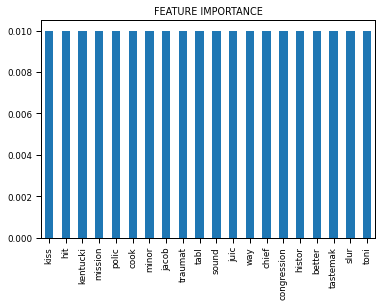

In [165]:
#random forest model information
clf_model_information(clf, X_train_tf, X_test_tf, y_test.ravel(), y_train.ravel())

In [166]:
!pip install shap

In [167]:
import shap
shap.initjs()

In [168]:
X_shap = shap.sample(X_test_tf, 100)

explainer = shap.TreeExplainer(clf)
shap_values= explainer.shap_values(X_shap)

SHAP Summary Plot


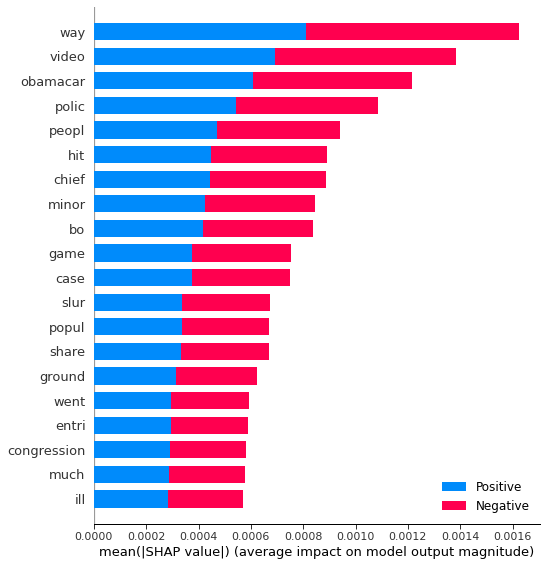

In [169]:
#Plot summary
print("SHAP Summary Plot")
shap.summary_plot(shap_values, X_train_tf, plot_type = 'bar', 
                  class_names = ['Negative', 'Positive'])

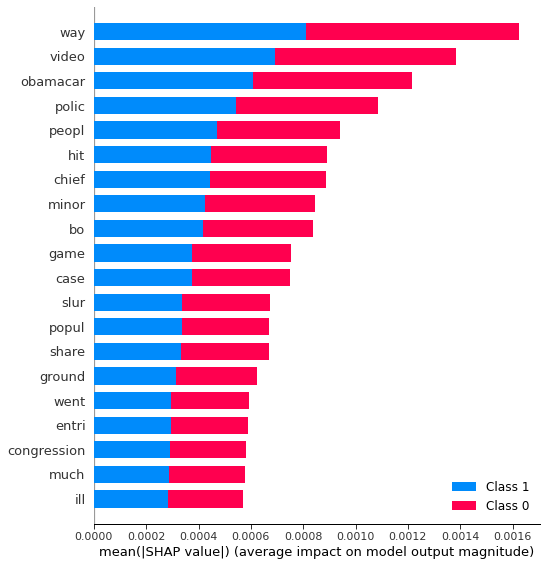

In [170]:
shap.summary_plot(shap_values, X_train_tf)

## Model 3: Using News Headlines to better predict the stock market

In [171]:
y_hat_sequences = model.predict(X_sequences).flatten().round()
y_hat_sequences.shape

(1462,)

In [172]:
#set new predictions column
df['predictions'] = y_hat_sequences
df.head()

,movement,headline,Price,daily_change,predictions
date,,,,,
2012-01-31,0,astrolog relationship project come head man dr...,60.66,-0.07,1.0
2012-02-01,1,join eckhart toll jim carrey john raatz rais c...,61.33,0.67,1.0
2012-02-02,1,one two three begin achiev dream right break f...,61.46,0.13,1.0
2012-02-03,1,cailliann samantha chloe beckerman beckerman b...,62.50,1.04,1.0
2012-02-07,1,divorc help second marriag good bad beauti run...,62.56,0.11,1.0


In [173]:
#error in model
#predicts 100% positive
df['predictions'].value_counts()

1.0    1462
Name: predictions, dtype: int64

In [174]:
df.index

DatetimeIndex(['2012-01-31', '2012-02-01', '2012-02-02', '2012-02-03',
               '2012-02-07', '2012-02-08', '2012-02-09', '2012-02-10',
               '2012-02-13', '2012-02-14',
               ...
               '2018-05-14', '2018-05-15', '2018-05-16', '2018-05-17',
               '2018-05-18', '2018-05-21', '2018-05-22', '2018-05-23',
               '2018-05-24', '2018-05-25'],
              dtype='datetime64[ns]', name='date', length=1462, freq=None)

In [175]:
#set X and y
X=df[['Price', 'predictions']] 
y = df['Price']

#train_test_split
int_split = round(len(X)*.8) 
X_train = X.iloc[:int_split]
X_test = X.iloc[int_split:]

y_train = y.iloc[:int_split]
y_test = y.iloc[int_split:]

In [176]:
X_train

,Price,predictions
date,,
2012-01-31,60.66,1.0
2012-02-01,61.33,1.0
2012-02-02,61.46,1.0
2012-02-03,62.50,1.0
2012-02-07,62.56,1.0
...,...,...
2017-02-01,101.78,1.0
2017-02-03,102.80,1.0
2017-02-06,102.48,1.0


In [177]:
#instantiate scaler
scaler = MinMaxScaler()

#run on X_train and X_test
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns, index = X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns, index = X_test.index) 

In [178]:
X_train 

,Price,predictions
date,,
2012-01-31,0.057471,0.0
2012-02-01,0.072281,0.0
2012-02-02,0.075155,0.0
2012-02-03,0.098143,0.0
2012-02-07,0.099469,0.0
...,...,...
2017-02-01,0.966401,0.0
2017-02-03,0.988948,0.0
2017-02-06,0.981874,0.0


In [179]:
#set feature number
n_features = X_train.shape[1] #stock price and predictions

#reshape series
series = X_train.values
series = series.reshape((len(series), n_features))
series

array([[0.05747126, 0.        ],
       [0.07228117, 0.        ],
       [0.07515473, 0.        ],
       ...,
       [0.98187445, 0.        ],
       [0.97789567, 0.        ],
       [0.99535809, 0.        ]])

In [180]:
#number of timesteps for the sequences 
length = 50

#create time series generator #first argument has all the data,
# second will be just the price column. might be 1 instead. see which one is price. 
generator = TimeseriesGenerator(series, series[:,-1], length, batch_size = 32)
generator

In [181]:
ex_X, ex_y = generator[1]
ex_X.shape

(32, 50, 2)

In [182]:
test_series = X_test.values
test_series = test_series.reshape((len(test_series), n_features))
test_gen = TimeseriesGenerator(test_series, test_series[:,-1], length, batch_size = 32)

In [183]:
input_shape = (length, n_features)

print('Samples: %d' % len(generator))

Samples: 35


In [184]:
final_model = Sequential()

final_model.add(LSTM(64, activation = 'relu', input_shape = input_shape,
                     return_sequences = True))
#final_model.add(Dropout(0.5))
final_model.add(LSTM(32, activation = 'relu', return_sequences = False))
final_model.add(Dense(1, activation = 'relu'))

final_model.compile(optimizer = optimizers.Nadam(), loss = 'mse',
                    metrics = ['mse'])

display(final_model.summary())
history = final_model.fit(generator, epochs = 20)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50, 64)            17152     
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 29,601
Trainable params: 29,601
Non-trainable params: 0
_________________________________________________________________


None

Epoch 1/20
35/35 [==============================] - 1s 39ms/step - loss: 0.0000e+00 - mse: 0.0000e+00
Epoch 2/20
35/35 [==============================] - 1s 36ms/step - loss: 0.0000e+00 - mse: 0.0000e+00
Epoch 3/20
35/35 [==============================] - 1s 35ms/step - loss: 0.0000e+00 - mse: 0.0000e+00
Epoch 4/20
35/35 [==============================] - 1s 41ms/step - loss: 0.0000e+00 - mse: 0.0000e+00
Epoch 5/20
35/35 [==============================] - 1s 36ms/step - loss: 0.0000e+00 - mse: 0.0000e+00
Epoch 6/20
35/35 [==============================] - 1s 35ms/step - loss: 0.0000e+00 - mse: 0.0000e+00
Epoch 7/20
35/35 [==============================] - 1s 38ms/step - loss: 0.0000e+00 - mse: 0.0000e+00
Epoch 8/20
35/35 [==============================] - 1s 36ms/step - loss: 0.0000e+00 - mse: 0.0000e+00
Epoch 9/20
35/35 [==============================] - 1s 36ms/step - loss: 0.0000e+00 - mse: 0.0000e+00
Epoch 10/20
35/35 [==============================] - 1s 37ms/step - loss: 0.0000e+

In [185]:
results = pd.DataFrame(history.history)
results

,loss,mse
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0
6,0.0,0.0
7,0.0,0.0
8,0.0,0.0
9,0.0,0.0


In [186]:
y_hat_test = final_model.predict(test_gen)
y_hat_test.shape

(242, 1)

In [187]:
plot_df = X_test[length:][['Price']].copy()
plot_df['predicted'] = y_hat_test.flatten()
plot_df

,Price,predicted
date,,
2017-05-08,1.022104,0.0
2017-05-09,1.015252,0.0
2017-05-10,1.020115,0.0
2017-05-11,1.013926,0.0
2017-05-12,1.005968,0.0
...,...,...
2018-05-21,1.199381,0.0
2018-05-22,1.195623,0.0
2018-05-23,1.191424,0.0


In [188]:
plot_df['predicted'].value_counts()

0.0    242
Name: predicted, dtype: int64

In [189]:
X_test[length:].shape

(242, 2)

In [190]:
X_train

,Price,predictions
date,,
2012-01-31,0.057471,0.0
2012-02-01,0.072281,0.0
2012-02-02,0.075155,0.0
2012-02-03,0.098143,0.0
2012-02-07,0.099469,0.0
...,...,...
2017-02-01,0.966401,0.0
2017-02-03,0.988948,0.0
2017-02-06,0.981874,0.0


In [191]:
plot_df.index = pd.to_datetime(plot_df.index)
plot_df.index

DatetimeIndex(['2017-05-08', '2017-05-09', '2017-05-10', '2017-05-11',
               '2017-05-12', '2017-05-15', '2017-05-16', '2017-05-17',
               '2017-05-18', '2017-05-19',
               ...
               '2018-05-14', '2018-05-15', '2018-05-16', '2018-05-17',
               '2018-05-18', '2018-05-21', '2018-05-22', '2018-05-23',
               '2018-05-24', '2018-05-25'],
              dtype='datetime64[ns]', name='date', length=242, freq=None)

In [192]:
X_train.index = pd.to_datetime(X_train.index)
X_test.index = pd.to_datetime(X_test.index)

In [193]:
X_train

,Price,predictions
date,,
2012-01-31,0.057471,0.0
2012-02-01,0.072281,0.0
2012-02-02,0.075155,0.0
2012-02-03,0.098143,0.0
2012-02-07,0.099469,0.0
...,...,...
2017-02-01,0.966401,0.0
2017-02-03,0.988948,0.0
2017-02-06,0.981874,0.0


Final Visualization of News Headlines predicting S&P 500

Text(0.5, 1.0, 'News and S&P500 Predictions')

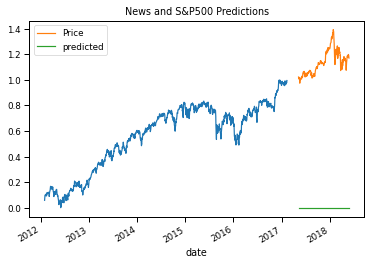

In [194]:
fit, ax = plt.subplots()
X_train['Price'].plot(ax = ax)

plot_df.plot(ax = ax)
ax.set_title('News and S&P500 Predictions')
# L = plt.legend()
# L.get_texts()[0].set_text('Train')
# L.get_texts()[1].set_text('Test')

In [195]:
final_model.save('/gdrive/My Drive/Colab Notebooks/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/assets


#Interpret/Conclusion

By observing our last model we can see that predicting the stock market is a very difficult task. Our third model gave 100% zeroes stating the the stock market would decrease, showing this model is not a reliable predictor of Huffington Post News Headlines predicting the stock market. Although the last model is not effective, we have learned many insights about the stock market through this notebook.


1. In our datasets the below words demonstrated an increase in the stock market

In [196]:
df.head()

,movement,headline,Price,daily_change,predictions
date,,,,,
2012-01-31,0,astrolog relationship project come head man dr...,60.66,-0.07,1.0
2012-02-01,1,join eckhart toll jim carrey john raatz rais c...,61.33,0.67,1.0
2012-02-02,1,one two three begin achiev dream right break f...,61.46,0.13,1.0
2012-02-03,1,cailliann samantha chloe beckerman beckerman b...,62.50,1.04,1.0
2012-02-07,1,divorc help second marriag good bad beauti run...,62.56,0.11,1.0


In [197]:
q = '''SELECT headline, movement
      FROM df
      GROUP BY movement;'''
word_view = pysqldf(q)
word_view.head()

,headline,movement
0,2 mass shoot texa last week 1 tv smith join di...,0
1,australian archbishop convict cover child sex ...,1


In [198]:
word_view.headline[1]

'australian archbishop convict cover child sex abus command say iran peopl respond pompeo threat punch mouth mark zuckerberg extend facebook apolog tour european gig ariana grand tweet messag support manchest bomb anniversari kati perri say singl american idol call cop watch power monologu racism amazon sell cop facial recognit tool bad potenti racist move miley cyru come like wreck ball prank sleep jimmi kimmel vanessa bayer fear porn star skit donald trump snl adam rippon win danc star destin emilia clark never tri imit chewbacca ever maddi popp win american idol runner reveal date colbert resist turn trump nicknam pee tape joke seth meyer forc tweak donald trump latest twitter rant time boy say teacher told fault polic shoot age 16 cop accus racism detain black man veget white cop shout black suspect pretend like go shoot florida polic report 2 dead standoff panama citi apart complex donald glover board lando calrissian pansexu solo charliz theron play megyn kelli film roger ail sho

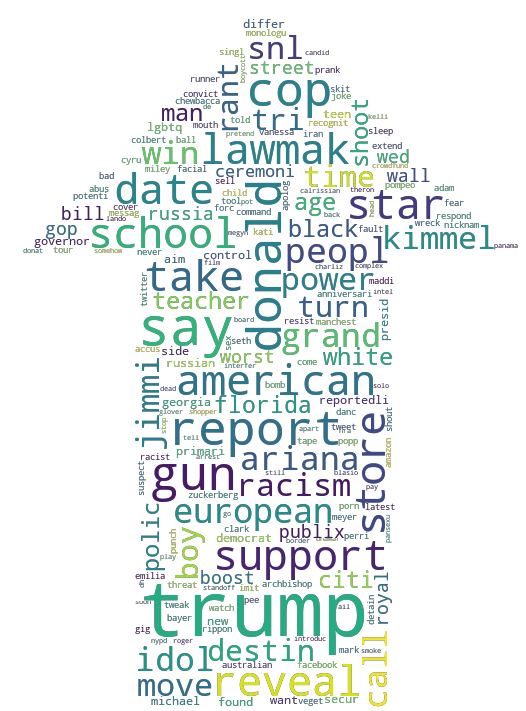

In [199]:
from PIL import Image
#build mask
mask = np.array(Image.open('/gdrive/My Drive/Colab Notebooks/images/arrow.jpg'))

#visualize increasing words, in news dataframe
wc = wordcloud.WordCloud(max_words = 200, width = 500, height = 500, mask = mask,
                         mode= 'RGBA', background_color = None, 
                         collocations= False)
text = word_view.headline[1]
wc.generate_from_text(text);
wc.to_image()

2. In our datasets below words demonstrated a decrease in the stock market

In [200]:
word_view.headline[0]

'2 mass shoot texa last week 1 tv smith join diplo nicki jam 2018 world cup offici song hugh grant marri first time age 57 jim carrey blast castrato adam schiff democrat new artwork julianna marguli us donald trump poop bag pick dog morgan freeman devast sexual harass claim could undermin legaci donald trump lovin new mcdonald jingl tonight show bit watch amazon prime new week mike myer reveal like fourth austin power film watch hulu new week justin timberlak visit texa school shoot victim south korean presid meet north korea kim jong un talk trump summit way life risk remot oyster grow region call robot trump crackdown immigr parent put kid alreadi strain system trump son concern fbi obtain wiretap putin alli met trump jr edward snowden one trump love vladimir putin booyah obama photograph hilari troll trump spi claim ireland vote repeal abort amend landslid referendum ryan zink look reel back critic grand pivot conserv trump scottish golf resort pay woman significantli le men report 

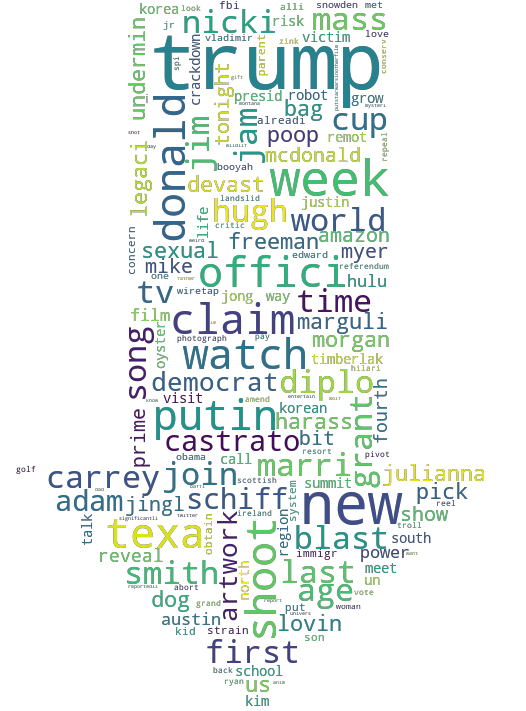

In [201]:
#build mask
mask = np.array(Image.open('/gdrive/My Drive/Colab Notebooks/images/decrease.jpg'))

#visualize decreasing words in news dataframe
wc = wordcloud.WordCloud(max_words = 200, width = 500, height = 500, mask = mask,
                         mode= 'RGBA', background_color = None,
                         collocations= False)
text = word_view.headline[0]
wc.generate_from_text(text);
wc.to_image()

3. Based off our results it might be best to try the same models, but use more specific headlines. An example of this could be using specific genres of headlines while predicting.

In [202]:
#join news and stock_ts dataframes
q = '''SELECT n.category, movement
                FROM news n
                JOIN df
                ON n.date = df.date;'''
hcg = pysqldf(q)
hcg.head()

,category,movement
0,WORLD NEWS,0
1,WORLD NEWS,0
2,WORLD NEWS,0
3,WORLD NEWS,0
4,BLACK VOICES,0


Below I am going to rename values in movement. Zero will be come Negative and one will become Positive.

In [203]:
hcg_list = []

for i in hcg['movement']:
  if i == 0:
    i = 'Negative'
  else:
    i= 'Postive'
  hcg_list.append(i)

In [204]:
hcg['movement']= hcg_list
hcg.head()

,category,movement
0,WORLD NEWS,Negative
1,WORLD NEWS,Negative
2,WORLD NEWS,Negative
3,WORLD NEWS,Negative
4,BLACK VOICES,Negative


In [205]:
sns.set_context('paper')

<Figure size 1080x576 with 0 Axes>

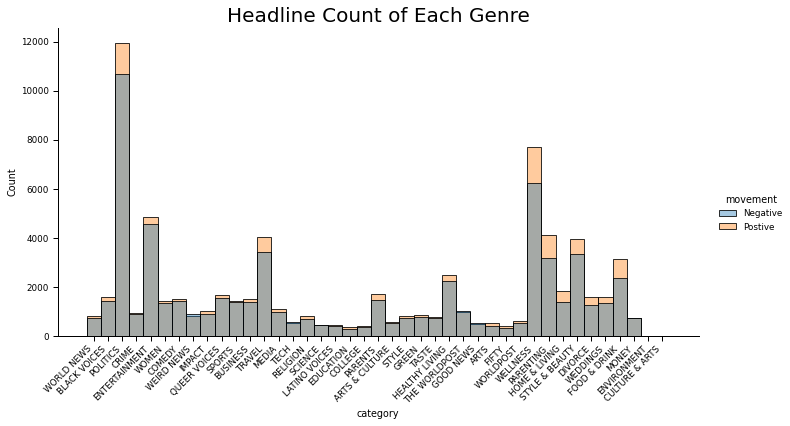

In [215]:
fig = plt.figure(figsize = (15, 8))
#need to change alpha
g = sns.displot(data = hcg, x= 'category', hue = 'movement',
                height = 5, aspect = 2, alpha = .4)
g.set_xticklabels(rotation = 45, ha = 'right')
plt.title('Headline Count of Each Genre', fontsize = 20);


4. When building your own stock analysis using headlines I recommend following the same approach. 
- Build a simple Time Series Model: I recommend using a Neural Network
- Create a NLP model to see what words cause the stock to increase or decrease: I recommend a LSTM Neural Network or a Random Forest
- Build a Time Series Model to see which news headlines better predict the market.

#Future Work

1. Separate News Headlines by Category to see which Category impacts the stock market more.
2. Test different Newspapers (ex. Wall Street Journal, New York Times, etc.) to see if one news source has a greater impact than others.
3. Test if categorical papers impact categorical stocks. Ex. Sports headlines impacting sports company stocks. 
4. Try different model types. Ex. PDArima model for initial time series model.

Thank you.